# Исследование объявлений о продаже квартир
*(убрал подробности в целях соблюдения авторских прав)*

Поставлена задача - проанализировать данные о стоимости квартир, установить параметры, влияющие на цену, которые в дальнейшем будут учтены в производстве автоматизированной системы поиска мошеннических схем. Для исследования предоставлены данные сериса Яндекс.Недвижимость по квартирам в Санкт-Петербурге и области за несколько лет.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
import random

# форматирование вывода
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
# проверим, какие разделители используются для хранения данных
!head /datasets/real_estate_data.csv

In [3]:
# разделитель - символ табуляции
data_real_estate = pd.read_csv('/datasets/real_estate_data.csv', sep='\\t', engine='python')

In [4]:
data_real_estate.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

В исходной таблице даны сведения о продаваемых квартирах.
Как заполняемые вручную:
- *общая площадь*
- *количество комнат*
- ...

так и вычисленные автоматически:
- *количество приложенных изображений*
- *парки поблизости*
- ...

In [5]:
data_real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Посмотрим распределение наиболее встречающихся значений в строковых столбцах (кроме *Null*):

In [6]:
for column in data_real_estate.select_dtypes(include='object').columns: # цикл по колонкам с типом object.
    print('Наиболее частые значения в столбце:', column)
    print(data_real_estate[column].value_counts().head(10))        
    print()

Наиболее частые значения в столбце: first_day_exposition
2018-02-01T00:00:00    368
2017-11-10T00:00:00    240
2017-10-13T00:00:00    124
2017-09-27T00:00:00    111
2018-03-26T00:00:00     97
2018-07-10T00:00:00     93
2017-09-28T00:00:00     74
2018-03-06T00:00:00     72
2018-02-08T00:00:00     71
2018-02-20T00:00:00     70
Name: first_day_exposition, dtype: int64

Наиболее частые значения в столбце: is_apartment
False    2725
True       50
Name: is_apartment, dtype: int64

Наиболее частые значения в столбце: locality_name
Санкт-Петербург      15721
посёлок Мурино         522
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64



Подавляющее количество (почти 3/4) - для Санкт-Петербурга.

In [7]:
# проведу доп. проверку для столбца с датами (проверка длины строки - 19 символов)
counter_wrong_values = 0
for index, row in data_real_estate.iterrows():
    if len(row['first_day_exposition']) != 19:
        counter_wrong_values += 1
print('Некорректных строк', counter_wrong_values)

Некорректных строк 0


In [8]:
# в колонке с городами отразились не все, проверим остальные значения:
data_real_estate['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Беглый просмотр говорит о том, что здесь нет неверных значений.

Есть проблема с типом данных в столбцах времени (привести к типу *datetime64*), данные булевого типа записаны в строку.
Однако некорректных значений, которые нельзя восстановить, проверка наиболее часто встречающихся данных в столбцах строкового типа не выявила.

Аналогично просмотрим даннные нестрокового типа:

In [9]:
for column in data_real_estate.select_dtypes(exclude='object').columns:
    print('В столбце', column, 'чаще всего встречаются данные:')
    print(data_real_estate[column].value_counts().head(10))
    print()

В столбце total_images чаще всего встречаются данные:
10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
Name: total_images, dtype: int64

В столбце last_price чаще всего встречаются данные:
4500000.0    342
3500000.0    291
4000000.0    260
4300000.0    260
4200000.0    259
3600000.0    257
3300000.0    244
3800000.0    240
3200000.0    238
3700000.0    234
Name: last_price, dtype: int64

В столбце total_area чаще всего встречаются данные:
45.0    419
42.0    383
60.0    347
31.0    346
44.0    345
40.0    315
43.0    301
32.0    289
46.0    282
36.0    280
Name: total_area, dtype: int64

В столбце rooms чаще всего встречаются данные:
1    8047
2    7940
3    5814
4    1180
5     326
0     197
6     105
7      59
8      12
9       8
Name: rooms, dtype: int64

В столбце ceiling_height чаще всего встречаются данные:
2.50    3515
2.60    1646
2.70    1574
3.00    1112
2.80     993
2.55     980
2.75     910
2.65     676
3.20     2

Разбираю по столбцам:
- *количество изображений* - корректные данные
- *последняя цена* - корректные данные
- *общая площадь* - корректные данные
- *количество комнат* - **некорректное 0** - встречается 197 раз.
- *высота потолков* - корректные данные
- *количество этажей* - корректные данные
- *жилая площадь* - корректные данные
- *этаж* - корректные данные
- *студия?* - корректные данные
- *открытая планировка?* - корректные данные
- *площадь кухни* - корректные данные
- *количество балконов* - количество балконов **5 и 4 вызывают вопросы**, т.к. встречаются чаще, чем 3.
- *до ближайшего аэропорта* - корректные данные
- *до центра города* - корректные данные, явно меньше, чем до аэропорта.
- *парков в радиусе 3000 м* - корректные данные
- *ближайший парк* - корректные данные
- *водоемов в радиусе 3000 м* - корректные данные
- *расстояние до ближайшего водоёма* - корректные данные
- *дней было размещено объявление* - странные наиболее встречающиеся значения 45, 60, 7, 30, 90 - неделя, месяц, полтора, два, три.

In [10]:
# дополнительно проверю распределения по числовым столбцам
print(data_real_estate.describe())

       total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  2.369900e+04  23699.000000  23699.000000    14504.000000   
mean       9.858475  6.541549e+06     60.348651      2.070636        2.771499   
std        5.682529  1.088701e+07     35.654083      1.078405        1.261056   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.800000e+06     69.900000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23613.000000  21796.000000  23699.000000  21421.000000  12180.000000   
mean      10.673824     34.457852      5.892358     10.569807      1.150082   
std        6.597173     22.030445

- *количество изображений* - корректные данные, нет отрицательных значений
- *последняя цена* - разброс значений почти на 5 порядков вызывает **подозрения в достоверности**. Медианное значение вдвое меньше среднего, что говорит о наличии множества объявлений с очень высокой ценой.
- *общая площадь* - **странное** максимальное значение 900 м.
- *количество комнат* - минимальное 0 - странно. максимальное 19 - видимо продают особняк, бывает. Поэтому и общая площадь была большая.
- *высота потолков*
  - **100 м** - явно неправдоподобное значение! 
  - **1 м** - Собачья будка?.. Детский домик?..
- *количество этажей* - **60** - Москва-Сити?
- *жилая площадь* - **2 м кв.** - только кровать разместить?..
- *этаж* - корректные данные
- *студия?* - корректные данные
- *открытая планировка?* - корректные данные
- *площадь кухни* - корректные данные
- *количество балконов* - количество балконов **5 и 4 вызывают вопросы**, т.к. встречаются чаще, чем 3.
- *до ближайшего аэропорта* - корректные данные
- *до центра города* - корректные данные, явно меньше, чем до аэропорта.
- *парков в радиусе 3000 м* - корректные данные
- *ближайший парк* - корректные данные
- *водоемов в радиусе 3000 м* - корректные данные
- *расстояние до ближайшего водоёма* - корректные данные
- *дней было размещено объявление* - корректные данные

Построю графики распределения:

Распределение для total_images


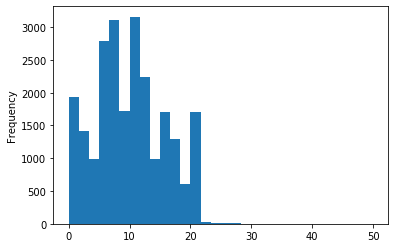

Распределение для last_price


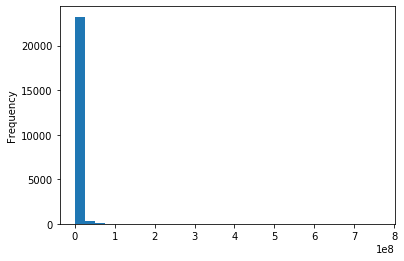

Распределение для total_area


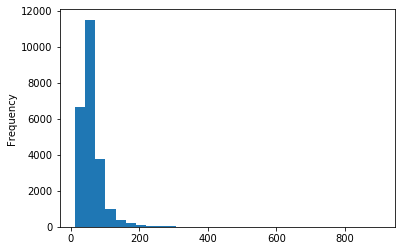

Распределение для rooms


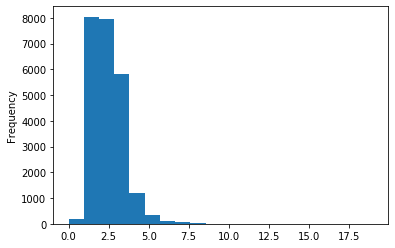

Распределение для ceiling_height


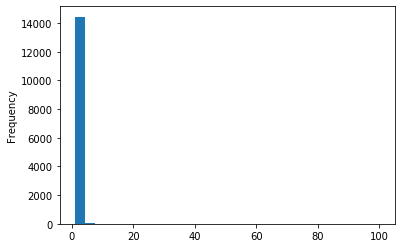

Распределение для floors_total


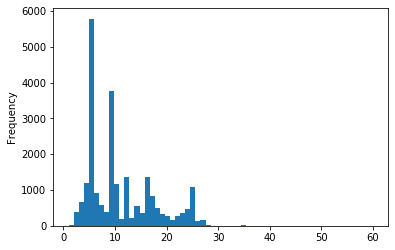

Распределение для living_area


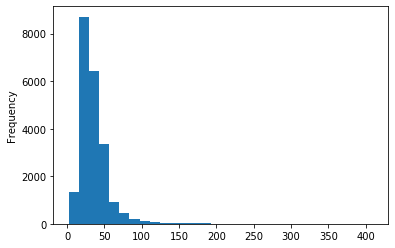

Распределение для floor


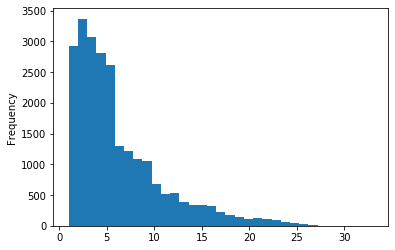

Распределение для kitchen_area


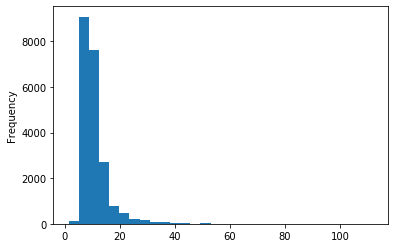

Распределение для balcony


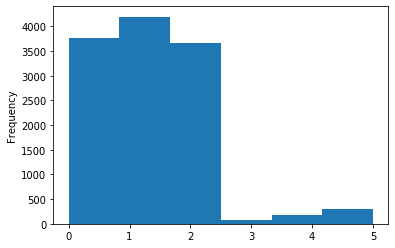

Распределение для airports_nearest


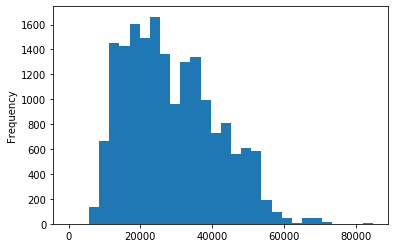

Распределение для cityCenters_nearest


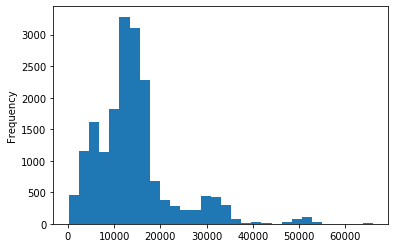

Распределение для parks_around3000


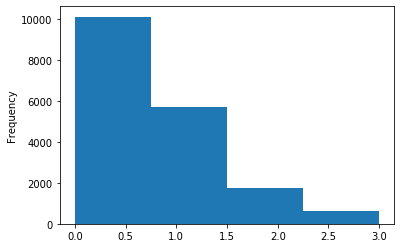

Распределение для parks_nearest


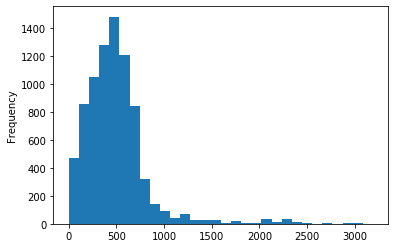

Распределение для ponds_around3000


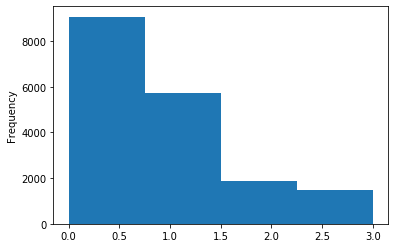

Распределение для ponds_nearest


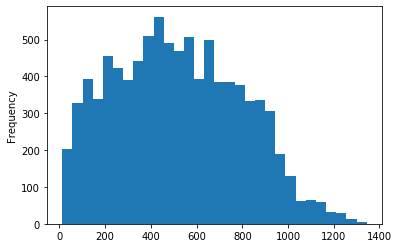

Распределение для days_exposition


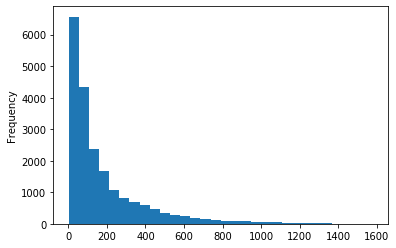

In [11]:
# списки столбцов с логарифмическим масштабом и индвидуальным количеством корзин на гистограмме
log_cols = []
bins_cols = ['rooms', 'floors_total','floor','balcony', 'ponds_around3000', 'parks_around3000']
for column_num in data_real_estate.select_dtypes(include='number').columns:
    print(color.BOLD + 'Распределение для', column_num + color.END)
    if column_num in log_cols:
        logx = True
    else:
        logx = False
    # настройка количества корзин для столбцов по количеству различных значений
    if column_num in bins_cols:
        bins = int(data_real_estate[column_num].max() - data_real_estate[column_num].min() + 1)
    else:
        bins = 30
        
    data_real_estate[column_num].plot(kind='hist', bins=bins,  logx=logx)
    plt.show()

Оценка распределений:
- *количество изображений* - ок. Если кому-то захотелось приложить 50+ изображений - его дело.
- *последняя цена* - выбросы слишком больших значений не дают увидеть распределение цены
- *общая площадь* - основное количество до 100, больше - редкие значения
- *количество комнат* - ок. 2 и 3 комнаты встречаются чаще, чем другие.
- *высота потолков* - явный **выброс в районе 100.
- *этажей всего* - пики в районе 6, 10, 12 и т.п. этажей соответствуют типичным высотам многоэтажек.
- *жилая площадь* - чаще всего от 10 до 40, выглядит как будто мало, но явных проблем не видно.
- *этаж* - чем выше этаж, тем реже он встречается, выглядит логичным.
- *площадь кухни* - значения больше 20 встречаются очень редко, но есть **"хвост" до 120.
- *количество балконов* - чаще балконов нет.
- *ближайшие аэропорты* - можно сказать, что ближе 6 км не встречаются, а среднее значение 20-40 км.
- *центр ближайшего города* - в среднем 15 км, но есть и 0, что здесь не является выбросом.
- *количество парков в районе 3 км* - выглядит логично и налицо проблема с парками в городах.
- *ближайший парк* - парк в среднем находится в 500 метрах от дома.
- *водоёмы в пределах 3 км* - чаще всего водоёмов поблизости так же нет.
- *расстояние до ближайшего водоёма* - так же около 500 м в среднем, если есть.
- *число дней на объявление* - как видно из этого распределения, чем больше срок с момента выставления квартиры на продажу, тем реже их покупают.

23699 позиций - хорошая база для анализа. Почти все необходимые данные есть. Не хватает только указания типа дома (кирпичный, монолитный и т.п.), и особенно - первичный это рынок жилья или вторичный, что особенно сильно влияет на стоимость. Видны пропуски в данных, рассмотрим их более детально:

In [12]:
# в процентах
def isnull_percent(data):
    isnull = data.isnull().sum()
    isnull.name = 'isnull'
    isnull = isnull.to_frame()
    isnull['percent'] = isnull['isnull'] * 100 / data.shape[0]
    isnull = isnull.sort_values(by='percent', ascending=False)
    return isnull

In [13]:
isnull_percent(data_real_estate)

isnull    percent
is_apartment           20924  88.290645
parks_nearest          15620  65.909954
ponds_nearest          14589  61.559559
balcony                11519  48.605426
ceiling_height          9195  38.799105
airports_nearest        5542  23.384953
cityCenters_nearest     5519  23.287902
ponds_around3000        5518  23.283683
parks_around3000        5518  23.283683
days_exposition         3181  13.422507
kitchen_area            2278   9.612220
living_area             1903   8.029875
floors_total              86   0.362885
locality_name             49   0.206760
total_images               0   0.000000
last_price                 0   0.000000
studio                     0   0.000000
floor                      0   0.000000
rooms                      0   0.000000
first_day_exposition       0   0.000000
total_area                 0   0.000000
open_plan                  0   0.000000

### Вывод

Данные в целом пригодны для анализа, однако **не хватает** необходимых данных для определения рыночной стоимости - типа дома (кирпичный, монолитный и т.п.) и особенно - **первичный** это рынок жилья или **вторичный**.
Определены данные, помеченные как пропуски типом *Null*. Таких пропусков достаточно много.
Пропуски в данных встречаются чаще всего в информации о том, является ли недвижимость апартаментами и в автоматически вычисленным расстояниям до ближайшего парка и водоема. У половины объявлений нет информации о наличии балкона, чуть больше трети - о высоте потолков, у четверти - о наличии аэропортов и центров города поблизости.
У восьмой части - количество дней, сколько провисело объявление.
У 10% - площадь кухни, у 8% - жилая площадь.

Пропусков из-за некорректных данных в столбцах со строковым типом (*название населенного пункта*) - 0.2% - пренебрежимо мало. 

Были обнаружены проблемы с типом данных:
- *объявление выставлено* - дата и время как строка.

Так же требуется изменить тип с *float* на целочисленный для столбцов с целочисленными значениями:
- количества балконов
- общего количества этажей
- количества парков и водоемов вблизи 3000 м
- количества дней, что объявление выставлено

### Шаг 2. Предобработка данных

#### Исправление типов значений

Преобразование дат из строкового типа в специальный:

In [14]:
try:
    data_real_estate['first_day_exposition'] = pd.to_datetime(data_real_estate['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
except:
    print('Ошибка преобразования к дате')

In [15]:
# проверка
data_real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_a

Дата успешно преобразовалась.

Так же требуется изменить тип с *float* на целочисленный для столбцов с целочисленными значениями:
- количества балконов
- общего количества этажей
- количества парков и водоемов вблизи 3000 м
- количества дней, что объявление выставлено

In [16]:
int_list = ['balcony', 'floors_total', 'parks_around3000', 'ponds_around3000', 'days_exposition']
data_real_estate[int_list] = data_real_estate[int_list].astype('float32', errors='ignore').astype('Int64', errors='ignore') # костыль, напрямую не работает

In [17]:
data_real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null Int64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null Int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null Int64
parks_nearest           8079 non-null float64
ponds_around3

Данные преобразованы, Null'ы не утеряны

In [18]:
# удалим лишние разряды для last_price для удобства: минимальное значение - 12 тыс., переведём данные в тысячи.
data_real_estate['last_price'] = data_real_estate['last_price'] / 1_000

In [19]:
data_real_estate.sample(n=5)

total_images  last_price  total_area first_day_exposition  rooms  \
7677              3      3700.0        43.0           2016-05-25      2   
20814            15      4800.0        82.0           2018-07-30      3   
18101             1      4500.0        75.6           2017-10-13      2   
1340              5      6000.0        53.2           2015-11-26      3   
19761            12      5800.0        82.3           2017-11-29      3   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
7677              NaN             5         30.0      4        False  ...   
20814             NaN            10         51.8      4          NaN  ...   
18101            2.77            13         30.0      2          NaN  ...   
1340             3.30             4         35.7      2          NaN  ...   
19761             NaN            16         45.4      4          NaN  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
7677            6.0        1  Санкт-Петербург           18358.0   
20814          11.0      NaN   деревня Старая               NaN   
18101          17.0        4  Санкт-Петербург           20763.0   
1340            5.9        0  Санкт-Петербург           25835.0   
19761          10.1        2  Санкт-Петербург           19120.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
7677               9889.0                 0            NaN                 1   
20814                 NaN               NaN            NaN               NaN   
18101              5415.0                 1         1423.0                 3   
1340               4769.0                 0            NaN                 1   
19761             22545.0                 0            NaN                 1   

       ponds_nearest  days_exposition  
7677            89.0               70  
20814            NaN              257  
18101          381.0               89  
1340           531.0              477  
19761          512.0               55  

[5 rows x 22 columns]

#### Пропуски

In [20]:
# вызову ещё раз таблицу с отсиортированными по сропускам столбцам
isnull_percent(data_real_estate)

isnull    percent
is_apartment           20924  88.290645
parks_nearest          15620  65.909954
ponds_nearest          14589  61.559559
balcony                11519  48.605426
ceiling_height          9195  38.799105
airports_nearest        5542  23.384953
cityCenters_nearest     5519  23.287902
ponds_around3000        5518  23.283683
parks_around3000        5518  23.283683
days_exposition         3181  13.422507
kitchen_area            2278   9.612220
living_area             1903   8.029875
floors_total              86   0.362885
locality_name             49   0.206760
total_images               0   0.000000
last_price                 0   0.000000
studio                     0   0.000000
floor                      0   0.000000
rooms                      0   0.000000
first_day_exposition       0   0.000000
total_area                 0   0.000000
open_plan                  0   0.000000

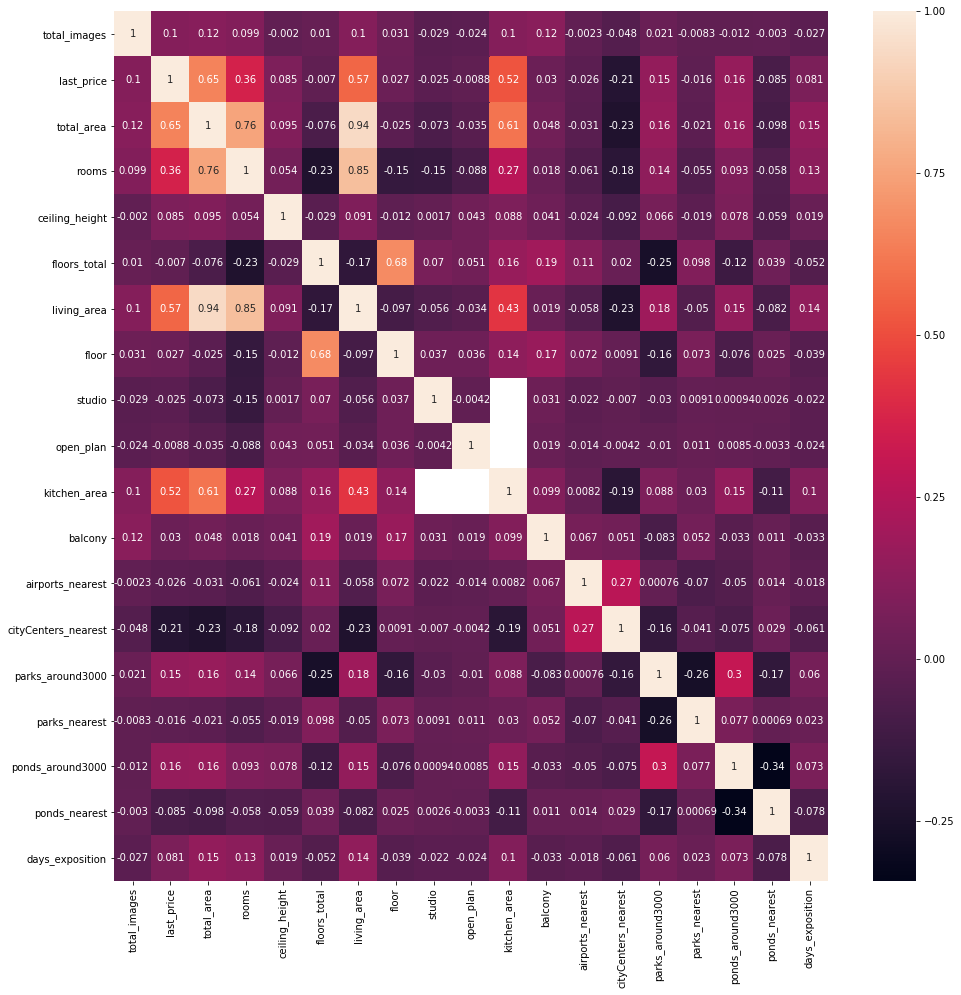

In [21]:
# построю матрицу корреляции для датасета
plt.figure(figsize=(16,16))
sns.heatmap(data_real_estate.corr(), annot=True)

1. Больше всего пропущенных значений в колонке, говорящей о том, *апартаменты* ли выставлены на продажу. По информации с сайта avito.ru, процент выставленных на продажу апартаментов в СПб и ЛО составляет 3%. Для нашей выборки это количество составило бы 710. Явно задано 50 из 2775 (1,8%). Вывод - пропущены как положительные значения, так и отрицательные. Этот столбец я не могу заполнить никакими значениями.
2. Парки и водоемы поблизости. практически одинаковый процент - 66 и 62 соответственно. Это значение заполняется автоматически, и всегда существует парк и водоём, который находится к дому ближе других. Посмотрим связанные с ними столбцы *парков в пределах 3000 м* и *водоемов в пределах 300 м*.

In [22]:
# для парков:
data_parks_null = data_real_estate[data_real_estate['parks_nearest'].isna()]
data_parks_null['parks_around3000'].isna().sum()

5518

Все пропущенные значения по паркам в пределах 3000 м находятся в выборке, где пропущены значения расстояния до ближайшего парка. Однако есть и значения, где пропусков нет. Если пропуски в колонке *расстояние до ближайшего парка* не случайно, логично было бы прдположить, что все значения в колонке *количество парков в пределах 3000 м* будет равно 0. Проверим это предположение.

In [23]:
data_parks_null[data_parks_null['parks_around3000'].notna()]['parks_around3000'].value_counts()

0    10102
Name: parks_around3000, dtype: int64

Предположение подтвердилось: если расстояние до ближайшего парка не заполнено, количество парков поблизости заполнено в 2/3 случаев и в 100% случаев равно 0. Проверим аналогичное предположение насчёт водоёмов.

In [24]:
data_ponds_null = data_real_estate[data_real_estate['ponds_nearest'].isna()]
data_ponds_null['ponds_around3000'].isna().sum()

5518

In [25]:
# распределение по значениям, где они есть
data_ponds_null['ponds_around3000'].value_counts()

0    9071
Name: ponds_around3000, dtype: int64

Аналогичная ситуация, гипотеза подтвердилась. Следовательно, можем заменить эти значения на 0 и там и там.

In [26]:
data_real_estate.loc[data_real_estate['parks_nearest'].isna(), 'parks_around3000'] = 0
data_real_estate.loc[data_real_estate['ponds_nearest'].isna(), 'ponds_around3000'] = 0

In [27]:
# проверка
data_real_estate['parks_nearest'].value_counts(dropna=False)

NaN       15620
441.0        67
392.0        41
173.0        41
456.0        40
          ...  
1809.0        1
2209.0        1
81.0          1
861.0         1
775.0         1
Name: parks_nearest, Length: 996, dtype: int64

In [28]:
data_real_estate['ponds_nearest'].value_counts(dropna=False)

NaN       14589
427.0        70
454.0        41
153.0        40
433.0        39
          ...  
600.0         1
258.0         1
37.0          1
1041.0        1
867.0         1
Name: ponds_nearest, Length: 1097, dtype: int64

In [29]:
data_real_estate['parks_around3000'].value_counts()

0    15624
1     5681
2     1747
3      647
Name: parks_around3000, dtype: int64

In [30]:
data_real_estate['ponds_around3000'].value_counts()

0    14589
1     5717
2     1892
3     1501
Name: ponds_around3000, dtype: int64

Значения заменены верно.

У половины данных нет сведений о балконах. По статистике с cian.ru балкон отсутствует у 66% квартир (54 тыс. из 82 тыс. объявлений по СПб). По данным из датасета - у 16% (3700 из 24 тыс.), а вместе со всеми пропущенными - 64%. Скорее всего, отсутствие балкона не указывают те, у кого его нет. Забыть указать, когда его нет, в таком ответственном деле - маловероятно. По матрице корреляции видно, что данные о наличии балконов ни с чем не коррелируют. Логика говорит о том же. В случае, если допустить, что было пропущено наличие балкона, я бы мог посмотреть этаж в здании, и если бы встречались первые этажи, это говорило бы о неверной гипотезе. В данном случае такая проверка ничего не даст. Были проведены все возможные проверки, и вариант, что пропущенное значение в графе *количество балконов* говорит о том, что в таких объявлениях их нет. Поэтому заменяем эти значения так же на 0.

In [31]:
data_real_estate.loc[data_real_estate['balcony'].isna(), 'balcony'] = 0

In [32]:
# проверка
data_real_estate['balcony'].value_counts(dropna=False)

0      15277
1       4195
2       3659
5        304
4        183
3         81
NaN        0
Name: balcony, dtype: int64

Значения заменены верно.

In [33]:
# вызову ещё раз таблицу с отсиортированными по сропускам столбцам
isnull_percent(data_real_estate)

isnull    percent
is_apartment           20924  88.290645
parks_nearest          15620  65.909954
ponds_nearest          14589  61.559559
ceiling_height          9195  38.799105
airports_nearest        5542  23.384953
cityCenters_nearest     5519  23.287902
days_exposition         3181  13.422507
kitchen_area            2278   9.612220
living_area             1903   8.029875
floors_total              86   0.362885
locality_name             49   0.206760
ponds_around3000           0   0.000000
parks_around3000           0   0.000000
total_images               0   0.000000
balcony                    0   0.000000
last_price                 0   0.000000
studio                     0   0.000000
floor                      0   0.000000
rooms                      0   0.000000
first_day_exposition       0   0.000000
total_area                 0   0.000000
open_plan                  0   0.000000

Следующие пропущенные значения - высота потолков. На Avito.ru например, нельзя отфильтровать предложения по этому параметру. Этот параметр выглядит не таким важным, как, например, общая площадь. Эти значения не буду заменять никакими средними, так как высота потолков так же ни с какими другими значениями не коррелирует.

Ближайшие аэропорты и центры городов. Здесь для каждого вида объектов выделено лишь по одному столбцу. Поэтому сделать проверку, как с парками или водоемами, не получится. Столбцы больше всего коррелируют друг с другом, но корреляция всё равно слабая. Логично предположить, что для автоматического вычисления расстояния было задано максимальное значение для поиска, и это значение превышено (как *3 км* или больше - для парков и водоемов). Поэтому эти значения не трогаем.

Количество дней, сколько провисело объявление, пока не было закрыто - коррелирует с остальными столбцами слабо. Можно только проверить, нет ли связи с первым днём выставления. Проверим гистограмму распределения по первому дню экспозиции для данных в целом и для данных с пропущенным количеством дней.

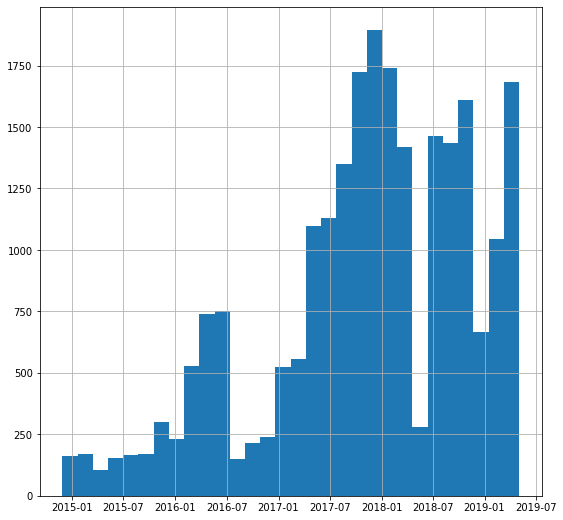

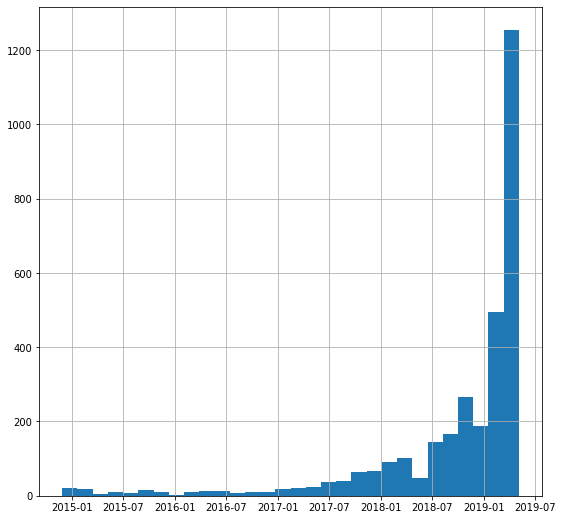

In [34]:
data_real_estate['first_day_exposition'].hist(bins=30, figsize=(9,9))
plt.show()
data_real_estate[data_real_estate['days_exposition'].isna()]['first_day_exposition'].hist(bins=30, figsize=(9,9))
plt.show()

In [35]:
data_real_estate[data_real_estate['days_exposition'].isna()] \
['first_day_exposition'].value_counts(bins=30).sort_index(ascending=False)

(2019-03-10 01:36:00, 2019-05-03]                       1254
(2019-01-15 03:12:00, 2019-03-10 01:36:00]               496
(2018-11-22 04:48:00, 2019-01-15 03:12:00]               187
(2018-09-29 06:24:00, 2018-11-22 04:48:00]               266
(2018-08-06 08:00:00, 2018-09-29 06:24:00]               166
(2018-06-13 09:36:00, 2018-08-06 08:00:00]               144
(2018-04-20 11:12:00, 2018-06-13 09:36:00]                49
(2018-02-25 12:48:00, 2018-04-20 11:12:00]               102
(2018-01-02 14:24:00, 2018-02-25 12:48:00]                91
(2017-11-09 16:00:00, 2018-01-02 14:24:00]                67
(2017-09-16 17:36:00, 2017-11-09 16:00:00]                63
(2017-07-24 19:12:00, 2017-09-16 17:36:00]                41
(2017-05-31 20:48:00, 2017-07-24 19:12:00]                38
(2017-04-07 22:24:00, 2017-05-31 20:48:00]                23
(2017-02-13, 2017-04-07 22:24:00]                         18
(2016-12-21 01:36:00, 2017-02-13]                         21
(2016-10-28 03:12:00, 20

Как видно, больше всего данных с отсутствующей датой **закрытия** объявления - в самом конце выборки. Логично предположить, что из базы были выгружены все присутствующие в базе объявления, в т.ч. и не закрытые на момент выгрузки. Так что для этой колонки отсутствующее значение даты закрытия является признаком незакрытого объявления.

Далее идут пропущенные значения для столбцов *жилой площади* и *площади кухни*. При том, что везде указана общая площадь, можно предположить, что это поле обозначено при создании объявления как обязательное, а *жилая площадь* и *площадь кухни* - нет.

*Жилая площадь* не указана в 8% объявлений, но у неё практически прямая зависимость от общей площади, что видно из таблицы корреляции. Поэтому этот столбец можно вычеркнуть из столбцов, которые влияют на цену квартиры и использовать столбец *общая площадь*.

*Площадь кухни* не так сильно коррелирует с общей площадью и с жилой, поэтому её будем учитывать там, где она указана, и отдельно - где не указана (проверим, влияет ли пропуск этого поля на цену проданной квартиры).

Последние 2 столбца с неуказанными значениями:
- *количество этажей в доме*
- *населенный пункт*

От количества этажей цена практически не зависит - как по логике, так и по матрице корреляции. Населенный пункт - напротив, должен значительно влиять на стоимость жилья, очевидно, что в городе жилье дороже. Но таких данных менее 0,2%, поэтому их я просто удалю.

#### Вывод:
при первоначальном анализе таблицы мне встретились пропуски в столбцах:
Автоматически вычисляемым:
- *расстояние до парка/водоема/аэропорта/центра города*
- количество *парков/водоемов поблизости*

По пропускам в данных о парках и довоемах поблизости было определено, что расстояние до ближайшего парка/водоема не указано во всех случаях, когда в соседнем столбце с количеством парков/водоемов в пределах 3000 м стоит 0, а в ряде случаев не указаны значения в обоих столбцах. Это говорит о том, что это техническая ошибка, возвращаемого значения функции, вычисляющей расстояние и количество, возвращающая численное значение не во всех случаях. И его можно заменить на 0.

Так же были отсутствующие значения в столбцах:
- *количества балконов* - 48% от всей выборки
- *высоты потолков*
- *жилой площади и площади кухни*
- *количестве дней до снятия*

По количеству балконов было определено, что таких случаев мало, в отличие от статистики с сайта cian.ru по выставленной на продажу недвижимости в СПб. Было высказано предположение, что люди вряд ли забыли указать количесчтво балконов, если бы они были, и логично, что не уделили этому вопросу внимания, если балконов в их квартире нет. К тому же статистика по квартирам с балконами с высокой степенью точности совпала со статистикой с сайта (66% и 64%).

*Высота потолков* - нет линейной зависимости для цены, что логично.

*Жилая площадь* - высокая корреляция (0.94) между *жилой* и *общей площадью*, поэтому в 8% недостающих данных буду учитывать общую площадь.

Небольшое количество данных (около 0,2%) содержит пропуски для общего количества этажей и название населенного пункта. Можно было бы предположить, что чем больше этажей - тем больше скученность, проблем с парковкой и т.п., однако при большем количестве этажей в проекте предусмотрены, как правило, компенсации для этих узких моментов (подземная парковка и т.п.), кроме того, для таких домов, как более крупных строительных объектов, создается дополнительный рейтинг "престижа", поэтому и не видно связи на матрице корреляции между ценой и количеством этажей.

Населенный пункт, конечно, в большей степени может влиять на цену, особенно, поселок это или город.

Однако, количество таких пропусков незначительно и можно их безболезненно удалить из выборки.

### Шаг 3. Посчитайте и добавьте в таблицу

In [36]:
# цена квадратного метра
data_real_estate['cost_per_square_meter'] = data_real_estate['last_price'] / data_real_estate['total_area']

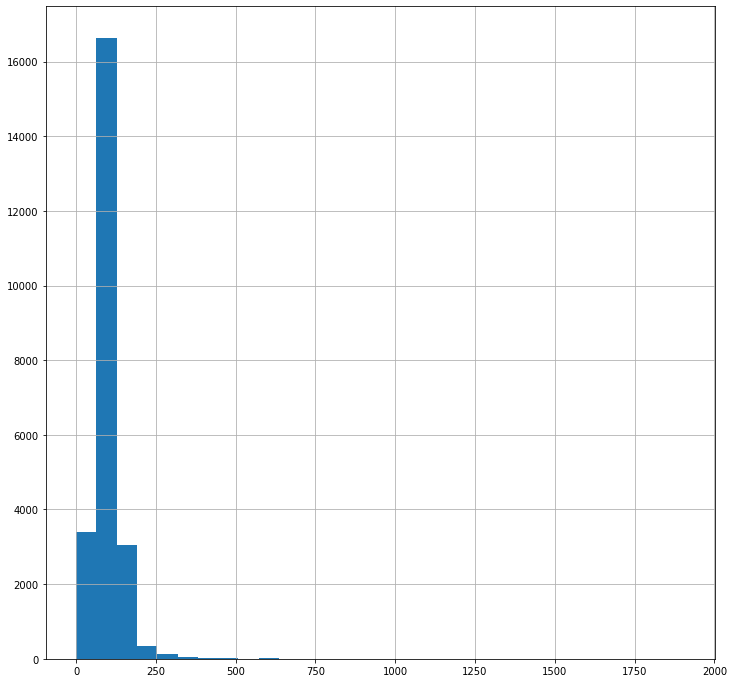

In [37]:
data_real_estate['cost_per_square_meter'].hist(bins=30,figsize=(12,12))

Черновик: как видно из графика, у нас имеется большой хвост значений больше 250 тыс. за кв. метр. Это либо особо элитное жилье, либо выбросы. Странно так же выглядит нарост около нуля, хотя там стоимость может быть до 80 тыс. за м.кв. Как быть дальше? (доделать)
По рейтингу "Мир квартир" цена за квадратный метр может доходить в зависимости от района СПб до 160 тыс/кв.м.
Как отфильтровывать минимальные/максимальные цены? (доделать)
Делаю просто по условию ящика с усами.

Выбросы для цены за квадратный метр:


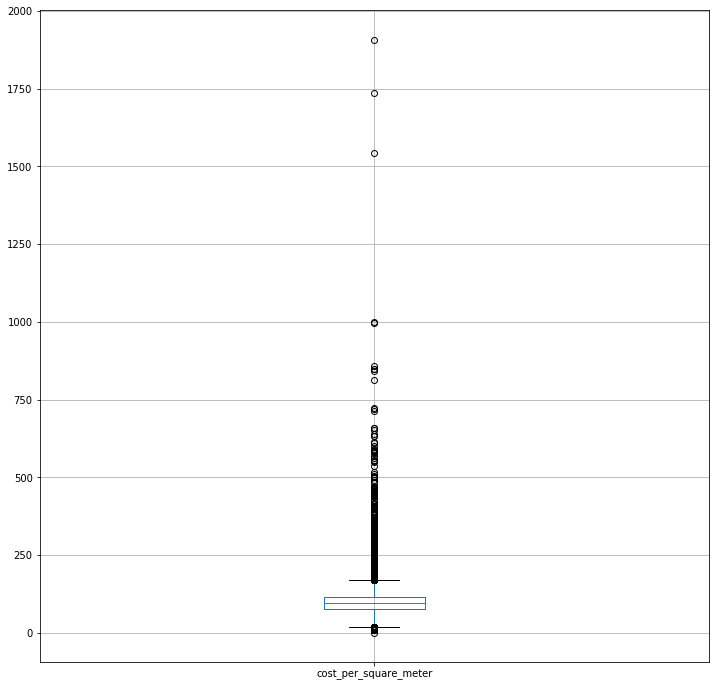

In [38]:
print(color.BOLD + 'Выбросы для цены за квадратный метр:' + color.END)
data_real_estate.boxplot(column='cost_per_square_meter', figsize=(12,12))

Видно довольно большое количество выбросов больше средних значений.

In [39]:
cost_quantiles = data_real_estate['cost_per_square_meter'].quantile([0.25,0.5,0.75])
cost_q1q3 = cost_quantiles[0.75] - cost_quantiles[0.25]
cost_min = min(0, cost_quantiles[0.25] - cost_q1q3 * 1.5) # 0 под вопросом, доделать
cost_max = cost_quantiles[0.75] + cost_q1q3 * 1.5
print(cost_min, cost_max)

0 170.7626109285365


In [40]:
good_data = data_real_estate.query('@cost_min <=cost_per_square_meter <= @cost_max') # откидываем все слишком большие значения

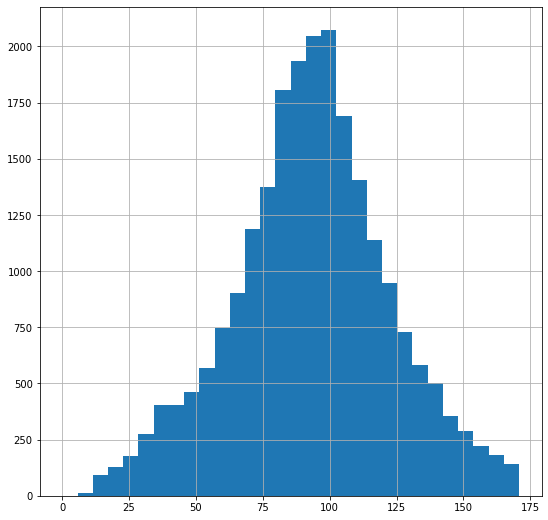

In [41]:
good_data['cost_per_square_meter'].hist(bins=30, figsize=(9,9))

Практически идеальное нормальное распределение.

- день недели, месяц и год публикации объявления
- этаж квартиры - первый, последний, другой
- соотношение жилой и общей площади
- отношение площади кухни к общей

In [42]:
data_real_estate['first_day_weekday'] = data_real_estate['first_day_exposition'].dt.weekday
data_real_estate['first_day_month'] = data_real_estate['first_day_exposition'].dt.month
data_real_estate['first_day_year'] = data_real_estate['first_day_exposition'].dt.year

In [43]:
data_real_estate.sample(n=5)

total_images  last_price  total_area first_day_exposition  rooms  \
20926            18      8900.0        46.0           2017-06-15      1   
21894             6      6550.0        67.7           2019-03-14      3   
6605              6      2950.0        35.0           2018-07-01      1   
8101             15      9100.0        79.0           2018-11-01      2   
18988            20      5800.0        57.5           2017-04-06      3   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
20926            2.65            17         20.0      4        False  ...   
21894            3.10             5         49.5      2          NaN  ...   
6605              NaN            19         16.0     17          NaN  ...   
8101             3.40             4         49.5      4          NaN  ...   
18988            2.50             9         39.1      5          NaN  ...   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
20926              12650.0                 1           96.0                 0   
21894               6073.0                 1          731.0                 1   
6605                   NaN                 0            NaN                 0   
8101                5589.0                 2          696.0                 0   
18988              15712.0                 1          678.0                 0   

      ponds_nearest  days_exposition  cost_per_square_meter  \
20926           NaN              283             193.478261   
21894         266.0              NaN              96.750369   
6605            NaN               72              84.285714   
8101            NaN              NaN             115.189873   
18988           NaN              249             100.869565   

       first_day_weekday  first_day_month  first_day_year  
20926                  3                6            2017  
21894                  3                3            2019  
6605                   6                7            2018  
8101                   3               11            2018  
18988                  3                4            2017  

[5 rows x 26 columns]

In [44]:
def floor_category(data):
    """
        функция для категоризации этажа для строки таблицы
    """
    if data['floor'] == 1:
        return 'первый'

    elif pd.isna(data['floor']) or pd.isna(data['floors_total']): 
        return 'неизвестно'
    elif data['floor'] == data['floors_total']: # далее - если известны номер этажа и общее их количество
        return 'последний'
    return 'другой'

In [45]:
data_real_estate['floor_category'] = data_real_estate.apply(floor_category, axis=1)

In [46]:
for i in range(3):
    print(data_real_estate[['floor', 'floors_total', 'floor_category']].sample(n=5))

       floor  floors_total floor_category
12320     14            14      последний
14558      6             7         другой
30         2             9         другой
2411       5             9         другой
17179      3             6         другой
       floor  floors_total floor_category
22454      1             6         первый
1357       1             9         первый
3169      22            25         другой
6580      24            27         другой
2626       5             9         другой
       floor  floors_total floor_category
22190     11            16         другой
22243      5             5      последний
5865       6             9         другой
11505      2            12         другой
20817      5             9         другой


In [47]:
data_real_estate[data_real_estate['floors_total'].isna()]['floor_category'].value_counts()

неизвестно    83
первый         3
Name: floor_category, dtype: int64

Категоризация работает, алгоритм не смутило отсутствующее значение общего количества этажей и он присвоил '*первый*' части данных.

Повторим категоризацию для отношения *общей площади* к *жилой* и *общей площади* к *площади кухни*.

In [48]:
data_real_estate['kitchen_area_amount'] = data_real_estate['kitchen_area'] / data_real_estate['total_area']
data_real_estate['living_area_amount'] = data_real_estate['living_area'] / data_real_estate['total_area']

In [49]:
# проверка
isnull_percent(data_real_estate)

isnull    percent
is_apartment            20924  88.290645
parks_nearest           15620  65.909954
ponds_nearest           14589  61.559559
ceiling_height           9195  38.799105
airports_nearest         5542  23.384953
cityCenters_nearest      5519  23.287902
days_exposition          3181  13.422507
kitchen_area             2278   9.612220
kitchen_area_amount      2278   9.612220
living_area_amount       1903   8.029875
living_area              1903   8.029875
floors_total               86   0.362885
locality_name              49   0.206760
balcony                     0   0.000000
last_price                  0   0.000000
open_plan                   0   0.000000
studio                      0   0.000000
parks_around3000            0   0.000000
floor                       0   0.000000
ponds_around3000            0   0.000000
rooms                       0   0.000000
first_day_exposition        0   0.000000
cost_per_square_meter       0   0.000000
first_day_weekday           0   0.000000
first_day_month             0   0.000000
first_day_year              0   0.000000
floor_category              0   0.000000
total_area                  0   0.000000
total_images                0   0.000000

In [50]:
data_real_estate[['total_area', 'kitchen_area', 'kitchen_area_amount', 'living_area', 'living_area_amount']].sample(n=10)

total_area  kitchen_area  kitchen_area_amount  living_area  \
5307         62.4           NaN                  NaN          NaN   
5171         54.2           8.1             0.149446         30.6   
20389        80.0          17.0             0.212500         60.0   
11220        75.0          10.0             0.133333         51.0   
5518        185.0          12.0             0.064865          NaN   
21101        45.3           6.3             0.139073          NaN   
3513         70.0           8.0             0.114286          NaN   
15646        75.0          10.0             0.133333         49.0   
11067        40.0          10.3             0.257500         20.0   
14389        47.8          12.0             0.251046         20.0   

       living_area_amount  
5307                  NaN  
5171             0.564576  
20389            0.750000  
11220            0.680000  
5518                  NaN  
21101                 NaN  
3513                  NaN  
15646            0.653333  
11067            0.500000  
14389            0.418410

Всё верно!

ещё: доделать населенный пункт (город, село и т.п.), количество фотографий - нет, мало, средне, много.

In [51]:
# квантили без учета 0, т.к. 0 - отдельная категория
images_quantiles = data_real_estate.query('total_images > 0')['total_images'].quantile([0.33,0.66])
print(images_quantiles)

0.33     7.0
0.66    12.0
Name: total_images, dtype: float64


In [52]:
def images_category(images, quantiles):
    if images == 0:
        return 'нет фотографий'
    elif images <= quantiles[0.33]:
        return 'мало'
    elif images <= quantiles[0.66]:
        return 'средне'
    return 'много'

In [53]:
data_real_estate['images_category'] = data_real_estate['total_images'].apply(lambda x: images_category(x,images_quantiles))

In [54]:
data_real_estate[['total_images', 'images_category']].sample(n=10)

total_images images_category
17401            17           много
18592            10          средне
5068              8          средне
19472             4            мало
10134            12          средне
11682            11          средне
17114             6            мало
20026             7            мало
16195             3            мало
15755            10          средне

Проверка прошла успешно.

In [55]:
# нижний регистр, т.к. название привожу к нижнему регистру для сравнения
another_localities = ['поселок', 'деревня', 'товарищество', 'село']
except_localities = ['красное село'] # в названии село, а это город
# категоризация населенных пунктов
def locality_name_category(locality_name, another,exceptions):
    # выделить слова из списка
    try:
        locality_name = locality_name.lower()
        locality_name = locality_name.replace('ё','е')
        words = locality_name.split()
        # если хотя бы для одного слова есть совпадение - возвращать "другое", иначе "город"
        # исключения
        # доделать - обрезка строки
        if locality_name in exceptions:
            return 'город'
        for word in words:
            if word in another:
                return 'другое'
        return 'город'
    except:
        print('Неверное название населенного пункта:', locality_name)
        return None

In [56]:
data_real_estate['locality_name_category'] = data_real_estate['locality_name'].apply(lambda x:locality_name_category(x, another_localities, except_localities))

Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пункта: nan
Неверное название населенного пунк

In [57]:
# проверка
data_real_estate['locality_name_category'].value_counts(dropna=False)

город     20008
другое     3642
NaN          49
Name: locality_name_category, dtype: int64

In [58]:
data_real_estate[data_real_estate['locality_name_category'] == 'город']['locality_name'].unique()

array(['Санкт-Петербург', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'Коммунар', 'Колпино', 'Гатчина', 'Выборг', 'Кронштадт', 'Кировск',
       'Павловск', 'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'Сестрорецк', 'Красное Село', 'Сясьстрой', 'Сланцы', 'Ивангород',
       'Мурино', 'Шлиссельбург', 'Никольское', 'Зеленогорск',
       'Сосновый Бор', 'Кудрово', 'Кириши', 'Луга', 'Волосово',
       'Отрадное', 'Тихвин', 'Тосно', 'Бокситогорск', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Новая Ладога', 'Лодейное Поле',
       'Светогорск', 'Любань', 'Каменногорск', 'Высоцк'], dtype=object)

In [59]:
data_real_estate[data_real_estate['locality_name_category'] == 'другое']['locality_name'].unique()

array(['посёлок Шушары', 'городской посёлок Янино-1', 'посёлок Парголово',
       'посёлок Мурино', 'деревня Кудрово',
       'поселок городского типа Красный Бор', 'поселок Мурино',
       'деревня Фёдоровское', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'деревня Пикколово',
       'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'посёлок Понтонный', 'деревня Старая', 'деревня Лесколово',
       'посёлок Новый Свет', 'село Путилово', 'поселок Новый Свет',
       'деревня Оржицы', 'деревня Кальтино', 'поселок Романовка',
       'посёлок Бугры', 'поселок Бугры', 'поселок городского типа Рощино',
       'село Павлово', 'поселок Оредеж', 'село Копорье',
   

Разделение верное.

**Вывод:** добавил дополнительные столбцы, с нормированными данными:
- отношение *площади кухни/жилой к общей*

Добавил столбцы с категоризацией:
- *количество фотографий* - на равные группы
- *населенный пункт* - город/нет
- *этажей*: первый/последний/другой/не ясно
- *дата*: день недели, месяц, год

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Фильтрация данных

In [60]:
display(data_real_estate.head())

total_images  last_price  total_area first_day_exposition  rooms  \
0            20     13000.0       108.0           2019-03-07      3   
1             7      3350.0        40.4           2018-12-04      1   
2            10      5196.0        56.0           2015-08-20      2   
3             0     64900.0       159.0           2015-07-24      3   
4             2     10000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70            16         51.0      8          NaN  ...   
1             NaN            11         18.6      1          NaN  ...   
2             NaN             5         34.3      4          NaN  ...   
3             NaN            14          NaN      9          NaN  ...   
4            3.03            14         32.0     13          NaN  ...   

   days_exposition  cost_per_square_meter  first_day_weekday  first_day_month  \
0              NaN             120.370370                  3                3   
1               81              82.920792                  1               12   
2              558              92.785714                  3                8   
3              424             408.176101                  4                7   
4              121             100.000000                  1                6   

  first_day_year  floor_category  kitchen_area_amount  living_area_amount  \
0           2019          другой             0.231481            0.472222   
1           2018          первый             0.272277            0.460396   
2           2015          другой             0.148214            0.612500   
3           2015          другой                  NaN                 NaN   
4           2018          другой             0.410000            0.320000   

   images_category  locality_name_category  
0            много                   город  
1             мало                  другое  
2           средне                   город  
3   нет фотографий                   город  
4             мало                   город  

[5 rows x 31 columns]

По логическим соображениям можно отфильтровать:
- общая площадь
- высота потолков
- количество этажей
- цена за квадратный метр

In [61]:
columns_to_filter = ['total_area', 'ceiling_height', 'floors_total', 'cost_per_square_meter']

In [62]:
describe_cols = data_real_estate[columns_to_filter].describe()
describe_cols

total_area  ceiling_height  floors_total  cost_per_square_meter
count  23699.000000    14504.000000  23613.000000           23699.000000
mean      60.348651        2.771499     10.673824              99.421656
std       35.654083        1.261056      6.597173              50.306802
min       12.000000        1.000000      1.000000               0.111835
25%       40.000000        2.520000      5.000000              76.585470
50%       52.000000        2.650000      9.000000              95.000000
75%       69.900000        2.800000     16.000000             114.256326
max      900.000000      100.000000     60.000000            1907.500000

Как видно, выбивающихся значений не так много, т.к. они не так сильно влияют на среднее:

In [63]:
describe_cols.loc['mean',:] / describe_cols.loc['50%',:]

total_area               1.160551
ceiling_height           1.045849
floors_total             1.185980
cost_per_square_meter    1.046544
dtype: float64

Выбросы видны: максимальная площадь 900 кв.м., высота потолков 100 м, этажей всего 60, и осоненно стоимость 0,1 тыс. за квадратный метр!

Построю гистограммы для выбранных столбцов:

Распределение для столбца total_area


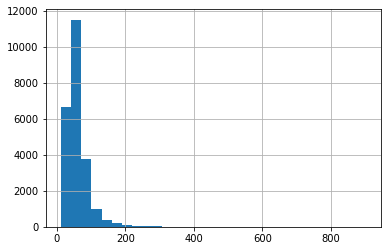

Распределение для столбца ceiling_height


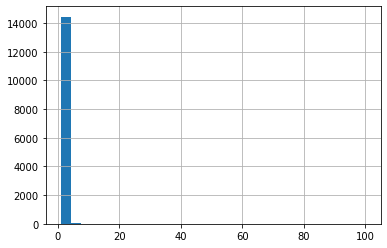

Распределение для столбца floors_total


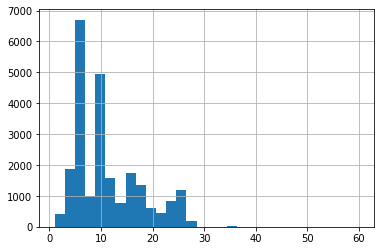

Распределение для столбца cost_per_square_meter


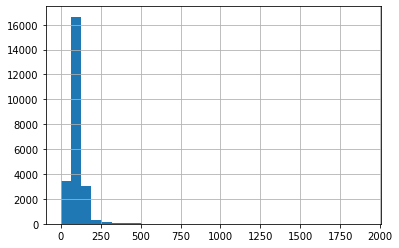

In [64]:
for column in columns_to_filter:
    print(color.BOLD + 'Распределение для столбца ' + column + color.END)
    data_real_estate[column].hist(bins=30)
    plt.show()

Очевидно, можно отсечь редкие данные:
- общая площадь - более 200 м.кв.
- потолки (включая старые дома с высокими потолками) - исключить высоту более 6 м.
- количество этажей - более 30.
- стоимость за квадратный метр - менее 4 тыс. (по данным cian.ru для старых домов в глубинке) и более 250

In [65]:
right_values = {'total_area':{'min':0,'max':200},
                'ceiling_height':{'min':2, 'max':6},
                'floors_total':{'min':1,'max':30},
                'cost_per_square_meter': {'min':4, 'max':250}
               }

In [66]:
def wrong_values_mark(data, right_values, mark_column):
    """
        Функция для каждой строки по словарю right_values проверяет, входит ли значение в допустимый интервал,
        и если нет - прибавляет 1 к столбцу mark_column.
        Возвращает новое значение mark_column.
    """
    try:
        data[mark_column] + 1
    except:
        print('Нечисловой тип данных столбца', mark_column)
    for value in right_values:
        # если Null, тогда не считаем за неверные данные
        if pd.notna(data[value]) and \
        (data[value] < right_values[value]['min'] or \
        data[value] > right_values[value]['max']):
            data[mark_column] += 1
    return data[mark_column]            

In [67]:
data_real_estate['wrong_value'] = 0
data_real_estate['wrong_value'] = data_real_estate.apply(lambda x: wrong_values_mark(x, right_values, 'wrong_value'), axis=1)

In [68]:
# Проверка пропущенных значений высоты потолка:
data_real_estate.query('wrong_value > 0')['total_area'].count()

511

511 неверных записей мы пометили как неверные, посмотрим, как изменилось распределение.

Распределение для столбца total_area


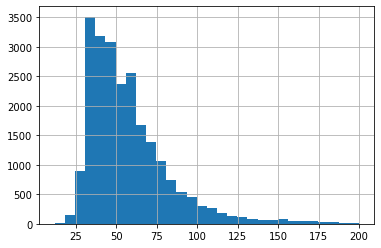

Распределение для столбца ceiling_height


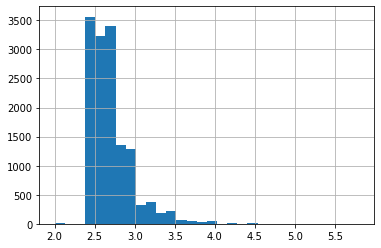

Распределение для столбца floors_total


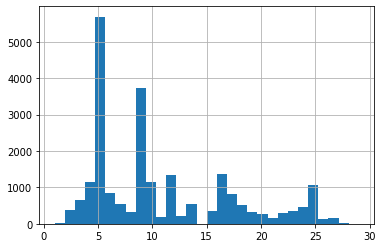

Распределение для столбца cost_per_square_meter


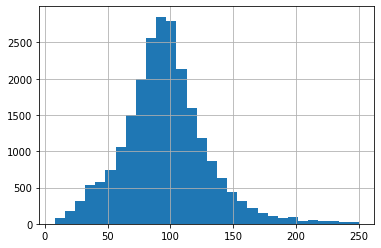

In [69]:
for column in columns_to_filter:
    print(color.BOLD + 'Распределение для столбца ' + column + color.END)
    data_real_estate.query('wrong_value == 0')[column].hist(bins=30)
    plt.show()

Гораздо лучше! При этом удалось сохранить около 98% данных.

Построим распределение стоимости за метр квадратный для городов и более мелких населенных пунктов:

Выведу сырые и отфильтрованные данные по каждому нумерованному столбцу:

In [70]:
def print_hist_set(data, groupby):
    """
        Отражение распределения цены за квадратный метр для групп из сгруппированных данных
    """
    for name, group_data in data.groupby(by=groupby):
        print('Распределение для', name)
        print('Количество значений:', group_data.shape[0])
        group_data['cost_per_square_meter'].hist(bins=30) 
        plt.show()

In [71]:
def print_hist_set_set_num(data):
    """
        Функция для печати распределения по числовым колонкам. Создает деление на группы с помощью qcut: 4 - дубликаты.
    """
    for column in data.select_dtypes('number').columns:
        if column == 'wrong_value':
            continue
        print(color.BOLD + 'Столбец', column + color.END)
        print_hist_set(data, pd.qcut(data[column], q=4, duplicates='drop'))

Столбец total_images
Распределение для (-0.001, 6.0]
Количество значений: 7109


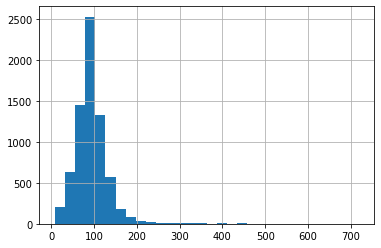

Распределение для (6.0, 9.0]
Количество значений: 4831


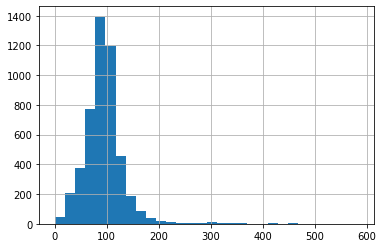

Распределение для (9.0, 14.0]
Количество значений: 6386


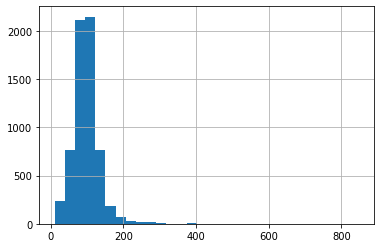

Распределение для (14.0, 50.0]
Количество значений: 5373


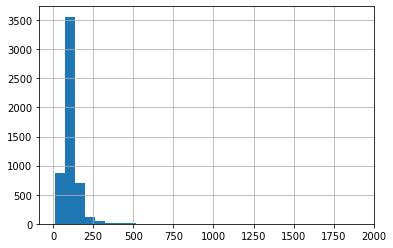

Столбец last_price
Распределение для (12.189, 3400.0]
Количество значений: 5927


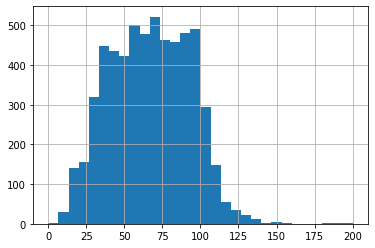

Распределение для (3400.0, 4650.0]
Количество значений: 6035


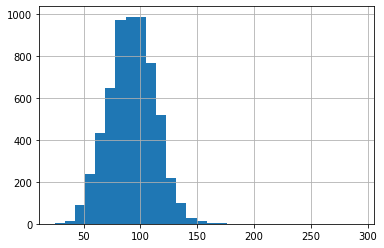

Распределение для (4650.0, 6800.0]
Количество значений: 5921


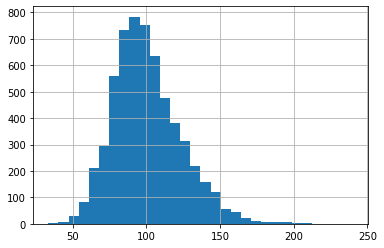

Распределение для (6800.0, 763000.0]
Количество значений: 5816


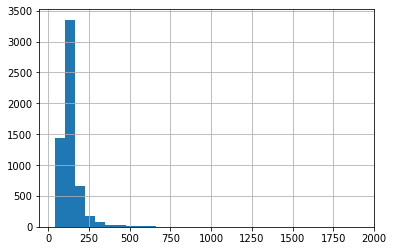

Столбец total_area
Распределение для (11.999, 40.0]
Количество значений: 6042


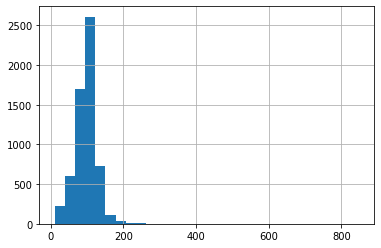

Распределение для (40.0, 52.0]
Количество значений: 5913


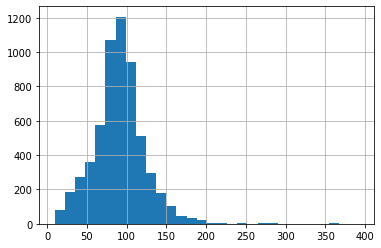

Распределение для (52.0, 69.9]
Количество значений: 5823


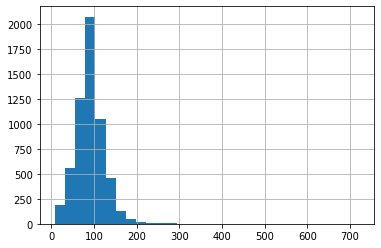

Распределение для (69.9, 900.0]
Количество значений: 5921


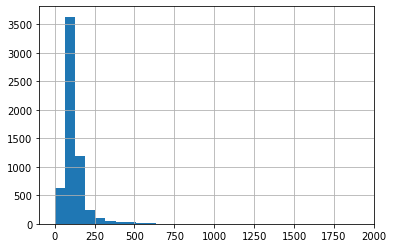

Столбец rooms
Распределение для (-0.001, 1.0]
Количество значений: 8244


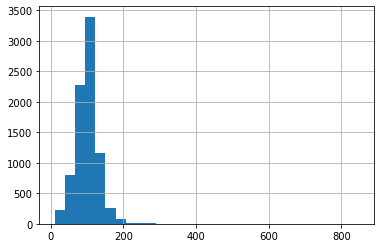

Распределение для (1.0, 2.0]
Количество значений: 7940


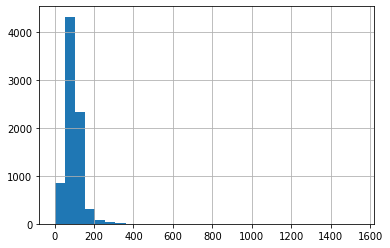

Распределение для (2.0, 3.0]
Количество значений: 5814


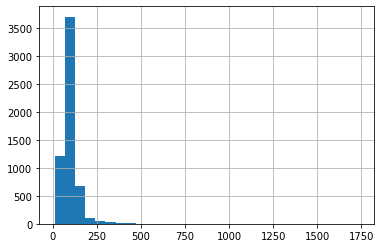

Распределение для (3.0, 19.0]
Количество значений: 1701


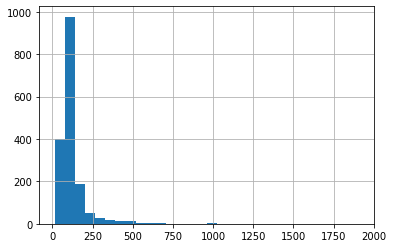

Столбец ceiling_height
Распределение для (0.999, 2.52]
Количество значений: 3701


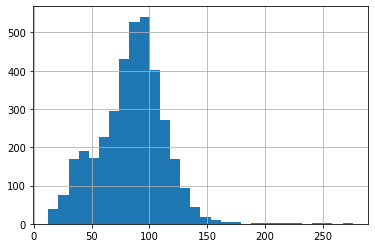

Распределение для (2.52, 2.65]
Количество значений: 3884


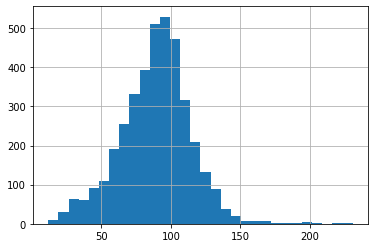

Распределение для (2.65, 2.8]
Количество значений: 3844


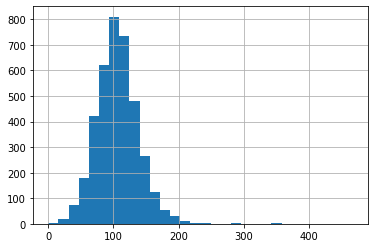

Распределение для (2.8, 100.0]
Количество значений: 3075


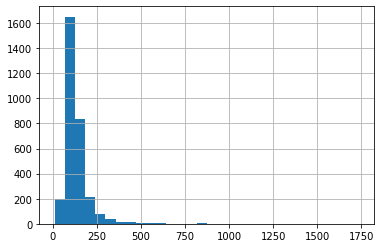

Столбец floors_total
Распределение для (0.999, 5.0]
Количество значений: 8122


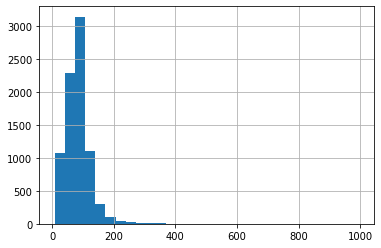

Распределение для (5.0, 9.0]
Количество значений: 5639


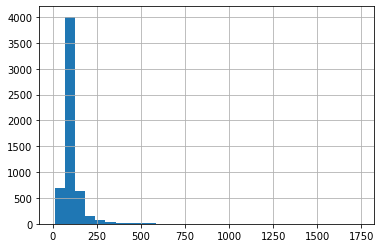

Распределение для (9.0, 16.0]
Количество значений: 5238


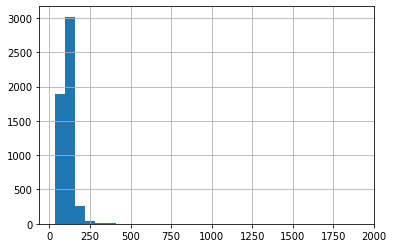

Распределение для (16.0, 60.0]
Количество значений: 4614


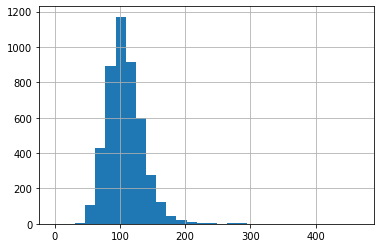

Столбец living_area
Распределение для (1.999, 18.6]
Количество значений: 5480


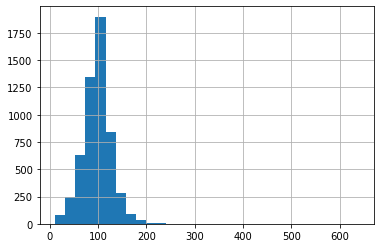

Распределение для (18.6, 30.0]
Количество значений: 5547


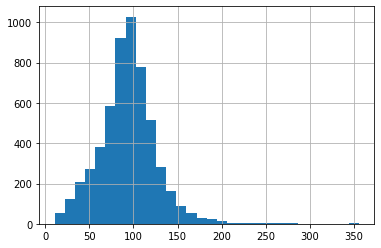

Распределение для (30.0, 42.3]
Количество значений: 5330


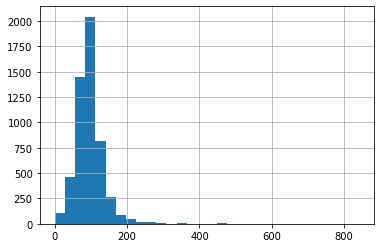

Распределение для (42.3, 409.7]
Количество значений: 5439


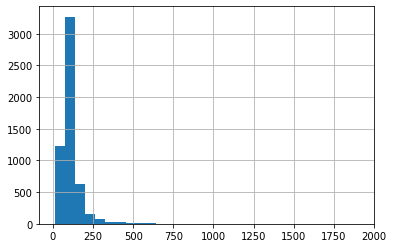

Столбец floor
Распределение для (0.999, 2.0]
Количество значений: 6285


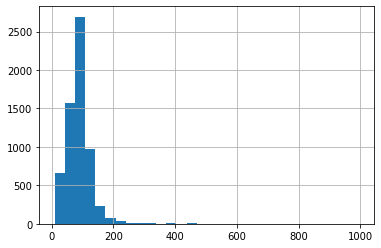

Распределение для (2.0, 4.0]
Количество значений: 5877


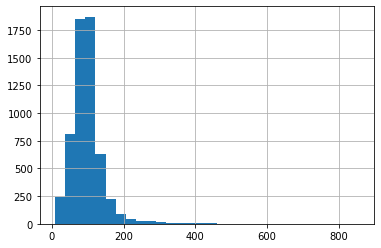

Распределение для (4.0, 8.0]
Количество значений: 6227


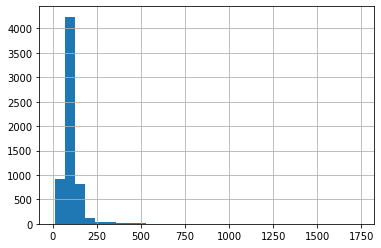

Распределение для (8.0, 33.0]
Количество значений: 5310


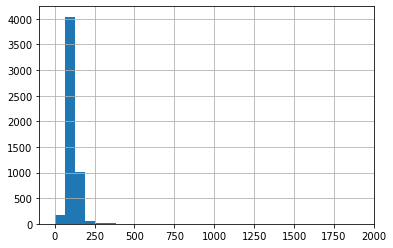

Столбец kitchen_area
Распределение для (1.2990000000000002, 7.0]
Количество значений: 5484


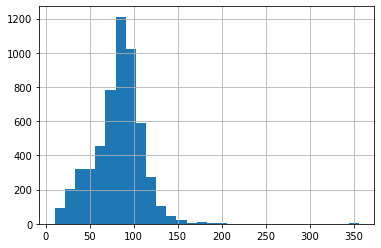

Распределение для (7.0, 9.1]
Количество значений: 5242


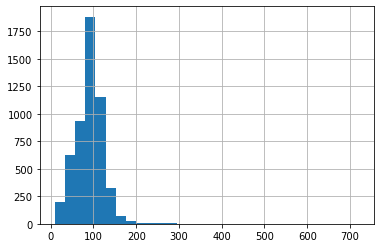

Распределение для (9.1, 12.0]
Количество значений: 5847


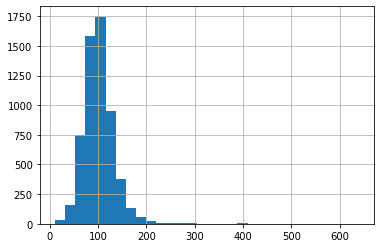

Распределение для (12.0, 112.0]
Количество значений: 4848


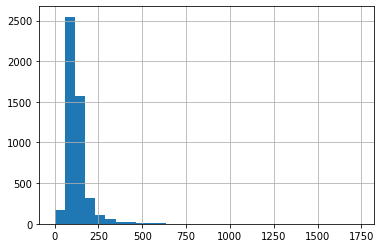

Столбец balcony
Распределение для (-0.001, 1.0]
Количество значений: 19472


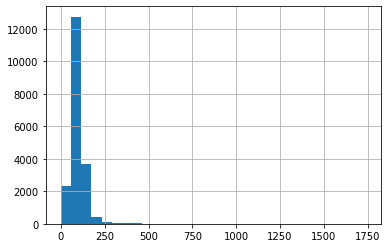

Распределение для (1.0, 5.0]
Количество значений: 4227


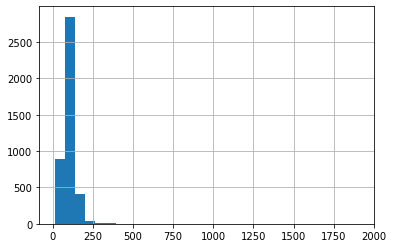

Столбец airports_nearest
Распределение для (-0.001, 18585.0]
Количество значений: 4543


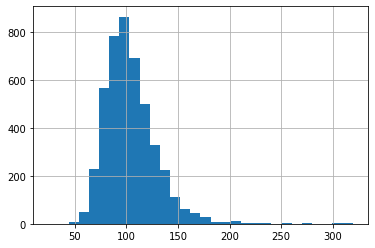

Распределение для (18585.0, 26726.0]
Количество значений: 4537


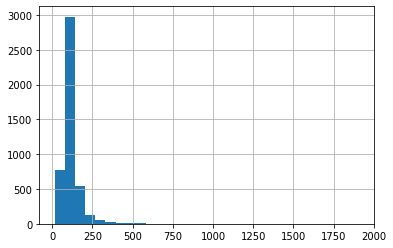

Распределение для (26726.0, 37273.0]
Количество значений: 4538


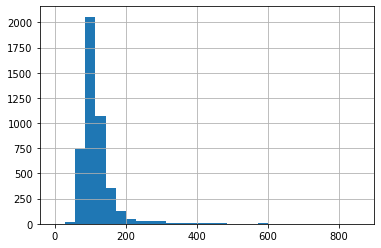

Распределение для (37273.0, 84869.0]
Количество значений: 4539


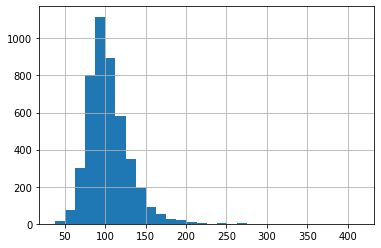

Столбец cityCenters_nearest
Распределение для (180.999, 9238.0]
Количество значений: 4554


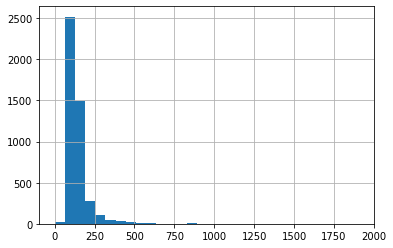

Распределение для (9238.0, 13098.5]
Количество значений: 4536


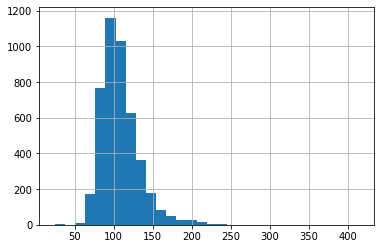

Распределение для (13098.5, 16293.0]
Количество значений: 4548


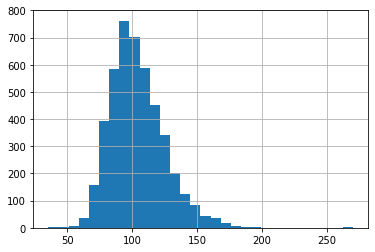

Распределение для (16293.0, 65968.0]
Количество значений: 4542


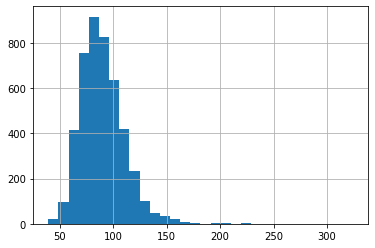

Столбец parks_around3000
Распределение для (-0.001, 1.0]
Количество значений: 21305


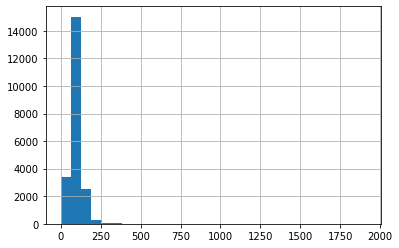

Распределение для (1.0, 3.0]
Количество значений: 2394


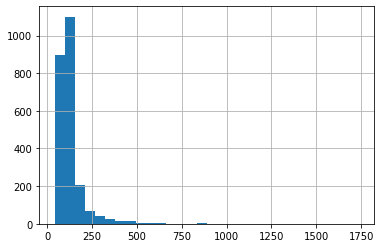

Столбец parks_nearest
Распределение для (0.999, 288.0]
Количество значений: 2045


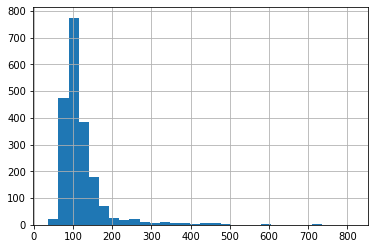

Распределение для (288.0, 455.0]
Количество значений: 2007


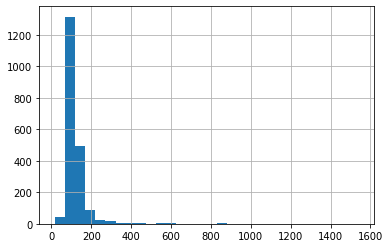

Распределение для (455.0, 612.0]
Количество значений: 2013


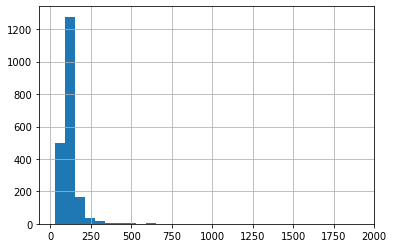

Распределение для (612.0, 3190.0]
Количество значений: 2014


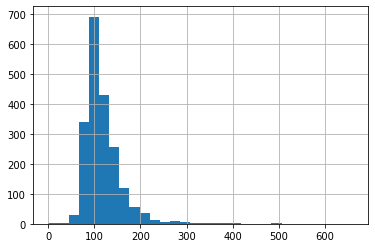

Столбец ponds_around3000
Распределение для (-0.001, 1.0]
Количество значений: 20306


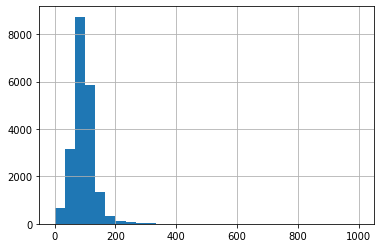

Распределение для (1.0, 3.0]
Количество значений: 3393


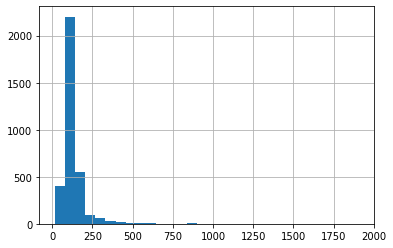

Столбец ponds_nearest
Распределение для (12.999, 294.0]
Количество значений: 2284


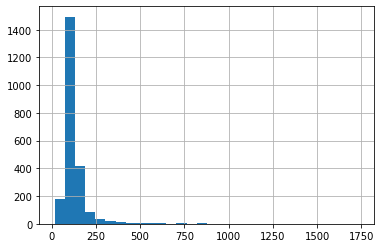

Распределение для (294.0, 502.0]
Количество значений: 2273


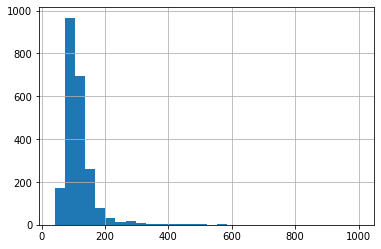

Распределение для (502.0, 729.0]
Количество значений: 2276


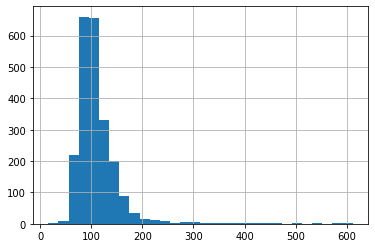

Распределение для (729.0, 1344.0]
Количество значений: 2277


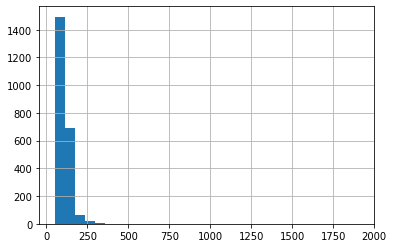

Столбец days_exposition
Распределение для (0.999, 45.0]
Количество значений: 7929


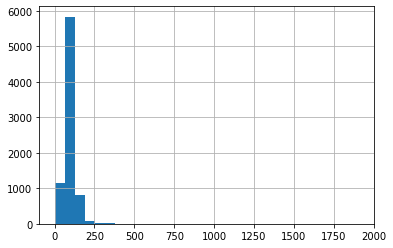

Распределение для (45.0, 95.0]
Количество значений: 4022


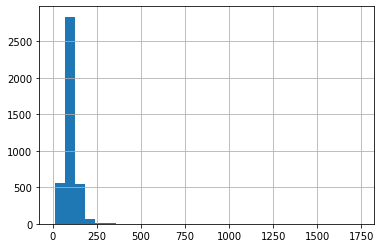

Распределение для (95.0, 232.0]
Количество значений: 4229


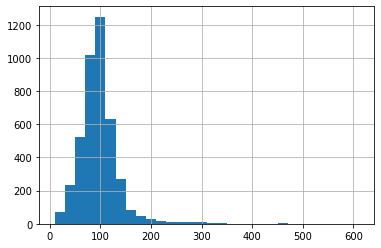

Распределение для (232.0, 1580.0]
Количество значений: 4338


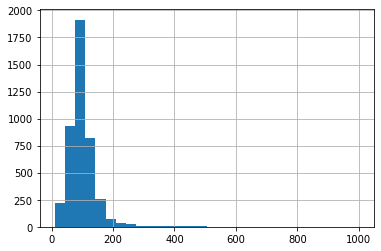

Столбец cost_per_square_meter
Распределение для (0.111, 76.585]
Количество значений: 5925


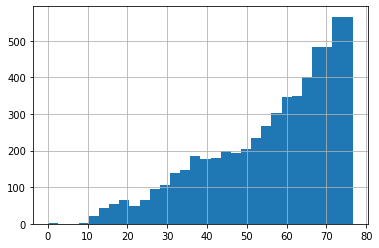

Распределение для (76.585, 95.0]
Количество значений: 5943


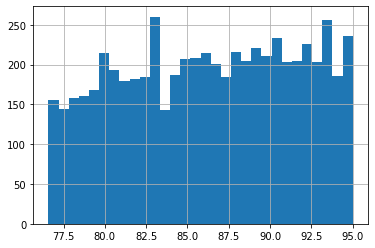

Распределение для (95.0, 114.256]
Количество значений: 5906


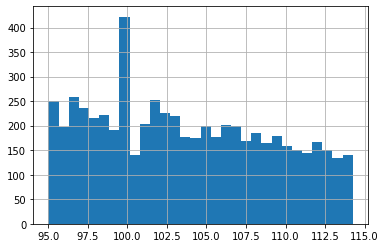

Распределение для (114.256, 1907.5]
Количество значений: 5925


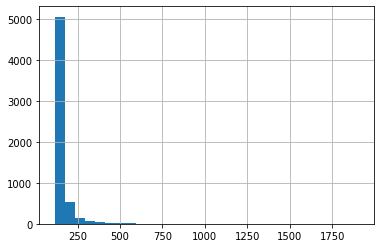

Столбец first_day_weekday
Распределение для (-0.001, 1.0]
Количество значений: 7795


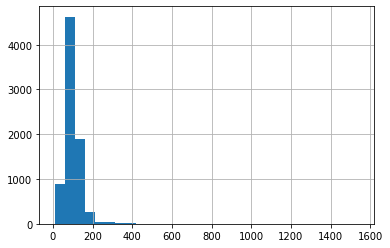

Распределение для (1.0, 3.0]
Количество значений: 8269


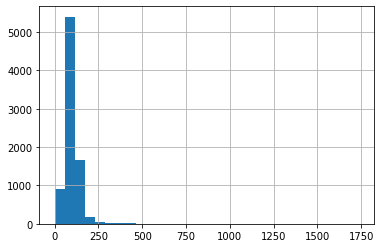

Распределение для (3.0, 4.0]
Количество значений: 4000


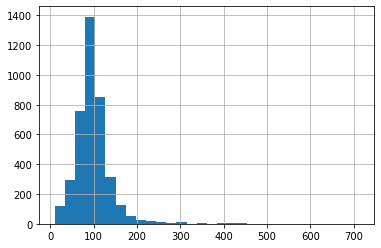

Распределение для (4.0, 6.0]
Количество значений: 3635


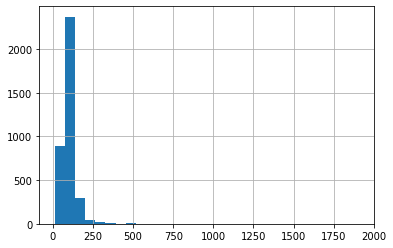

Столбец first_day_month
Распределение для (0.999, 3.0]
Количество значений: 6727


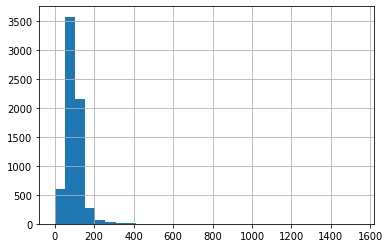

Распределение для (3.0, 6.0]
Количество значений: 5413


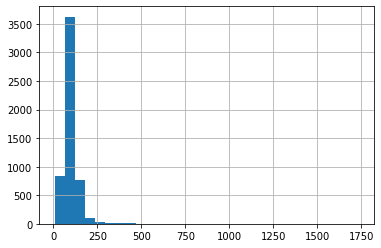

Распределение для (6.0, 10.0]
Количество значений: 7547


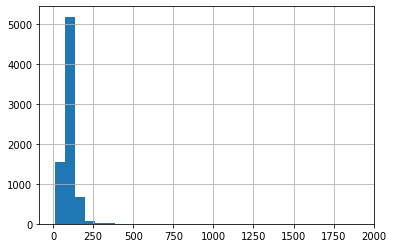

Распределение для (10.0, 12.0]
Количество значений: 4012


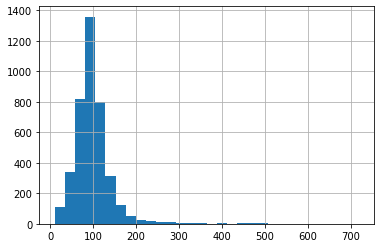

Столбец first_day_year
Распределение для (2013.999, 2017.0]
Количество значений: 12301


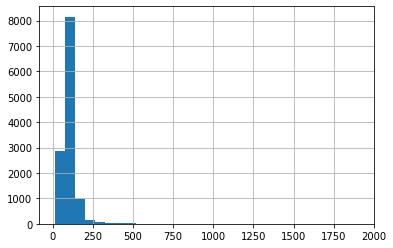

Распределение для (2017.0, 2018.0]
Количество значений: 8519


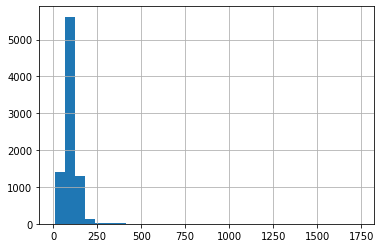

Распределение для (2018.0, 2019.0]
Количество значений: 2879


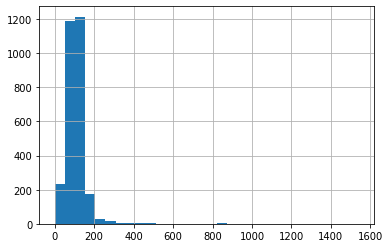

Столбец kitchen_area_amount
Распределение для (0.024399999999999998, 0.133]
Количество значений: 5403


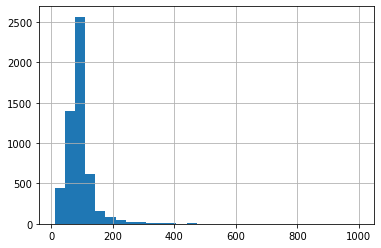

Распределение для (0.133, 0.172]
Количество значений: 5334


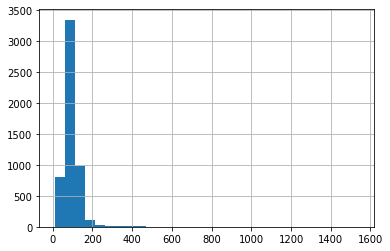

Распределение для (0.172, 0.232]
Количество значений: 5329


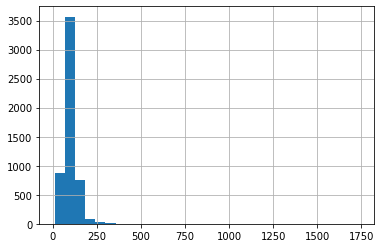

Распределение для (0.232, 0.788]
Количество значений: 5355


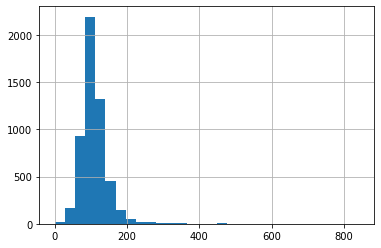

Столбец living_area_amount
Распределение для (0.0206, 0.495]
Количество значений: 5450


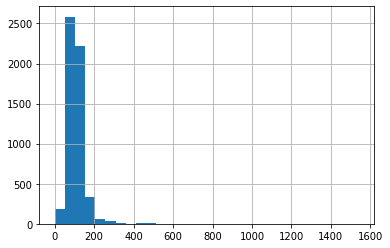

Распределение для (0.495, 0.568]
Количество значений: 5448


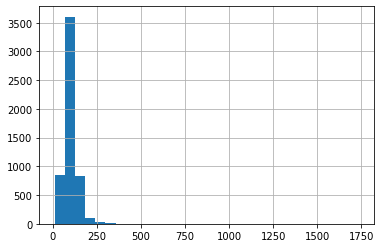

Распределение для (0.568, 0.638]
Количество значений: 5449


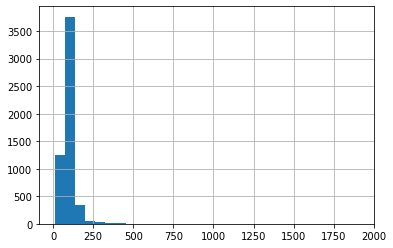

Распределение для (0.638, 1.0]
Количество значений: 5449


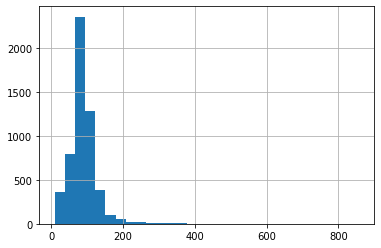

In [72]:
print_hist_set_set_num(data_real_estate)

Столбец total_images
Распределение для (-0.001, 6.0]
Количество значений: 6983


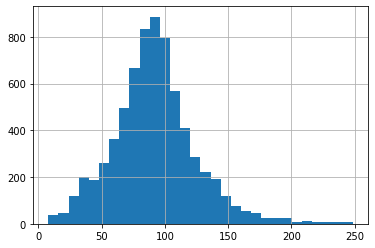

Распределение для (6.0, 9.0]
Количество значений: 4757


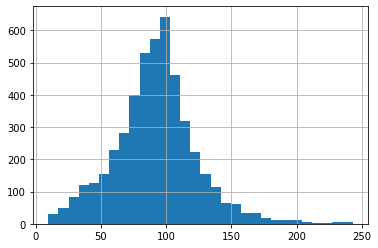

Распределение для (9.0, 14.0]
Количество значений: 6287


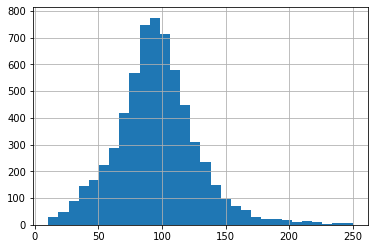

Распределение для (14.0, 50.0]
Количество значений: 5161


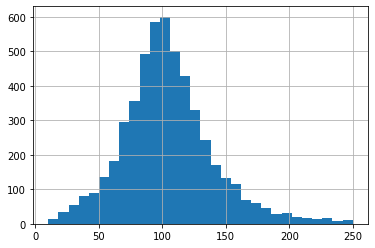

Столбец last_price
Распределение для (429.999, 3400.0]
Количество значений: 5917


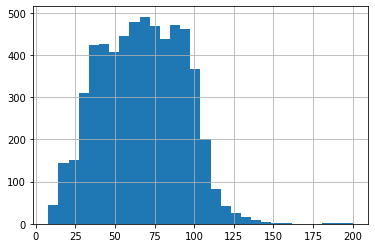

Распределение для (3400.0, 4600.0]
Количество значений: 5869


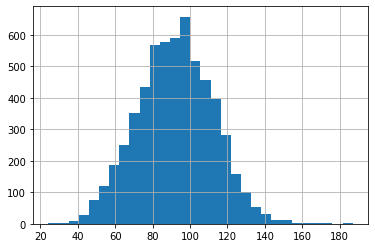

Распределение для (4600.0, 6598.25]
Количество значений: 5605


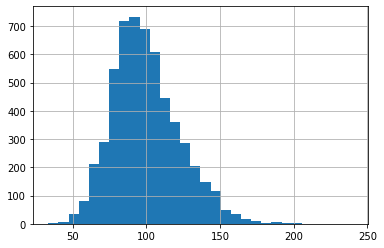

Распределение для (6598.25, 46000.0]
Количество значений: 5797


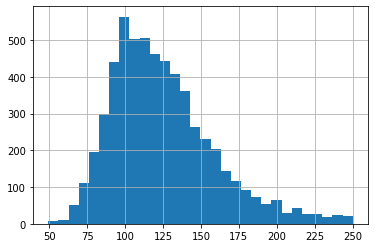

Столбец total_area
Распределение для (11.999, 40.0]
Количество значений: 6022


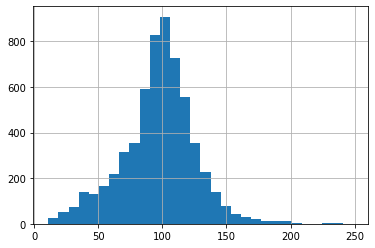

Распределение для (40.0, 51.3]
Количество значений: 5577


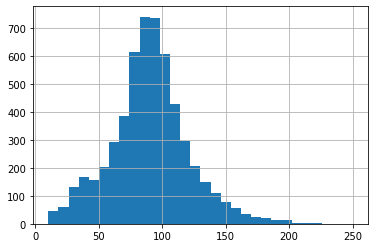

Распределение для (51.3, 68.0]
Количество значений: 5821


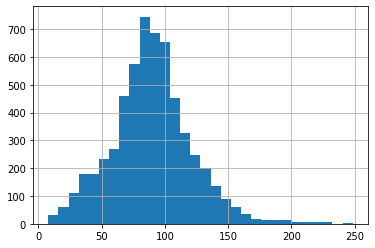

Распределение для (68.0, 200.0]
Количество значений: 5768


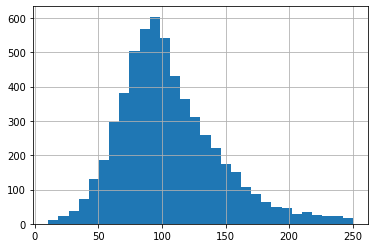

Столбец rooms
Распределение для (-0.001, 1.0]
Количество значений: 8198


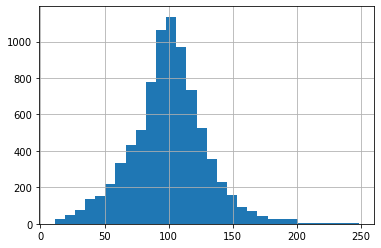

Распределение для (1.0, 2.0]
Количество значений: 7849


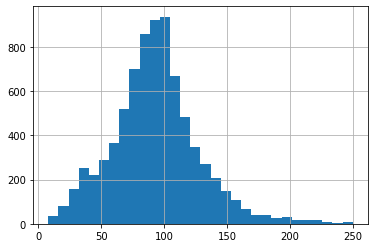

Распределение для (2.0, 3.0]
Количество значений: 5691


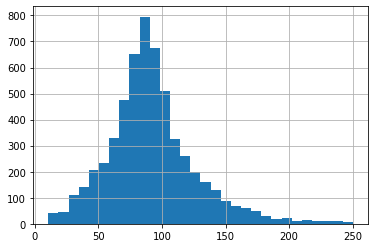

Распределение для (3.0, 11.0]
Количество значений: 1450


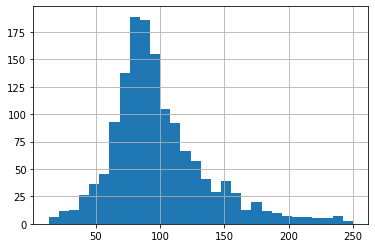

Столбец ceiling_height
Распределение для (1.999, 2.5]
Количество значений: 3580


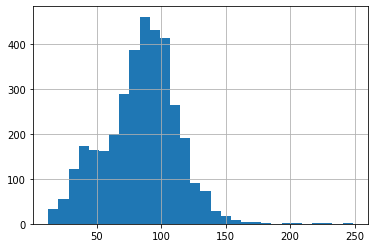

Распределение для (2.5, 2.65]
Количество значений: 3993


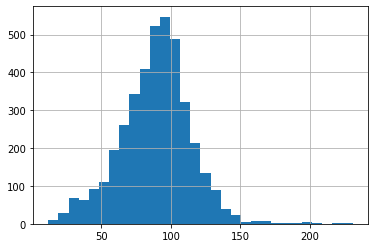

Распределение для (2.65, 2.8]
Количество значений: 3819


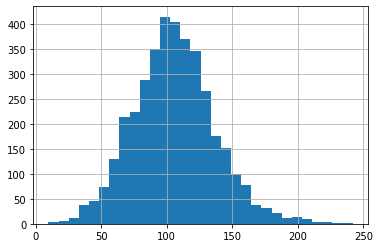

Распределение для (2.8, 5.8]
Количество значений: 2782


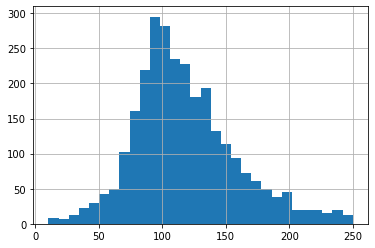

Столбец floors_total
Распределение для (0.999, 5.0]
Количество значений: 7943


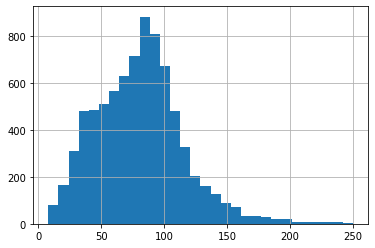

Распределение для (5.0, 9.0]
Количество значений: 5428


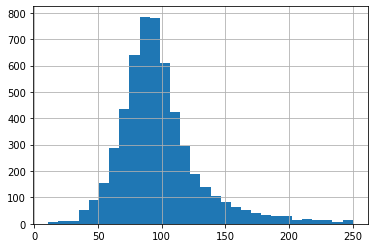

Распределение для (9.0, 16.0]
Количество значений: 5175


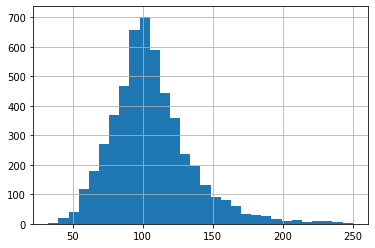

Распределение для (16.0, 29.0]
Количество значений: 4557


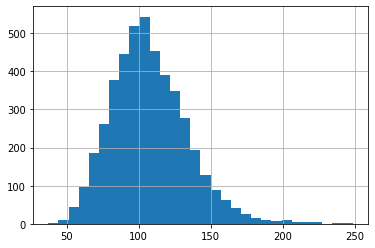

Столбец living_area
Распределение для (1.999, 18.5]
Количество значений: 5368


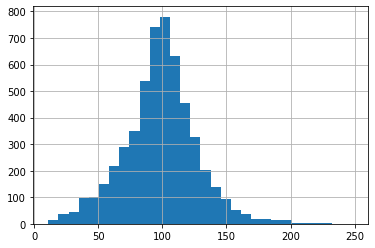

Распределение для (18.5, 30.0]
Количество значений: 5611


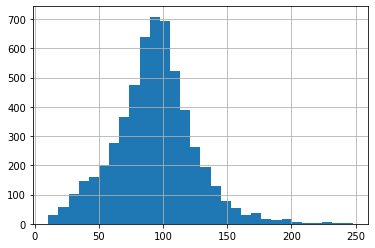

Распределение для (30.0, 42.0]
Количество значений: 5183


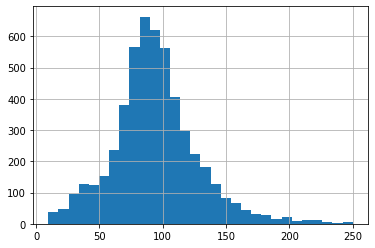

Распределение для (42.0, 164.7]
Количество значений: 5181


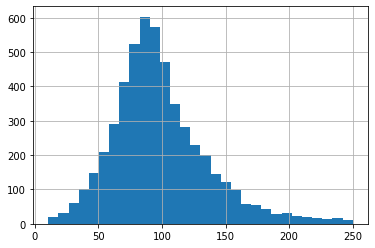

Столбец floor
Распределение для (0.999, 2.0]
Количество значений: 6179


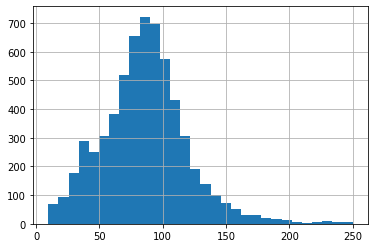

Распределение для (2.0, 4.0]
Количество значений: 5706


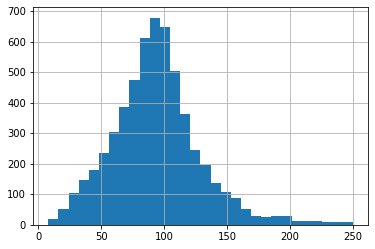

Распределение для (4.0, 8.0]
Количество значений: 6066


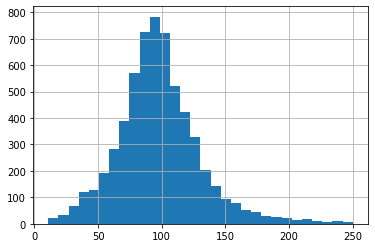

Распределение для (8.0, 27.0]
Количество значений: 5237


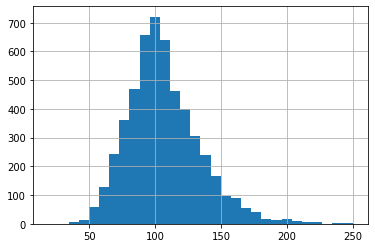

Столбец kitchen_area
Распределение для (1.2990000000000002, 7.0]
Количество значений: 5474


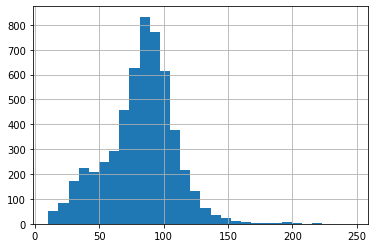

Распределение для (7.0, 9.0]
Количество значений: 5130


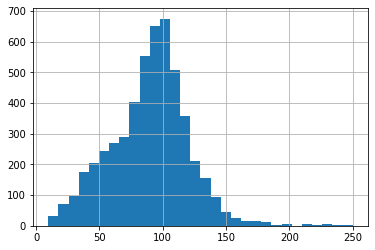

Распределение для (9.0, 11.8]
Количество значений: 5175


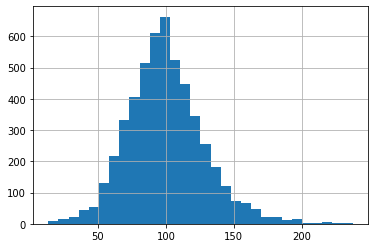

Распределение для (11.8, 65.0]
Количество значений: 5195


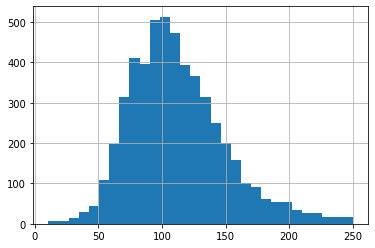

Столбец balcony
Распределение для (-0.001, 1.0]
Количество значений: 19028


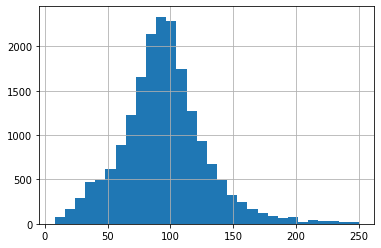

Распределение для (1.0, 5.0]
Количество значений: 4160


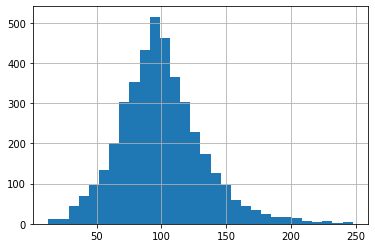

Столбец airports_nearest
Распределение для (-0.001, 18459.0]
Количество значений: 4423


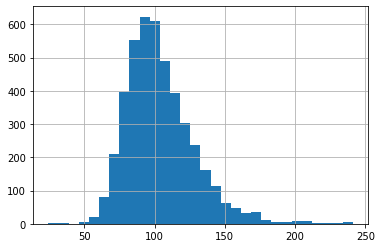

Распределение для (18459.0, 26859.0]
Количество значений: 4414


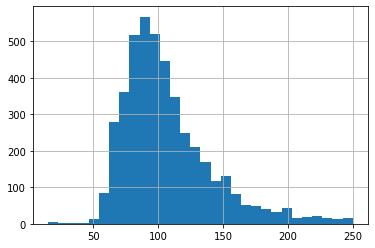

Распределение для (26859.0, 37412.0]
Количество значений: 4424


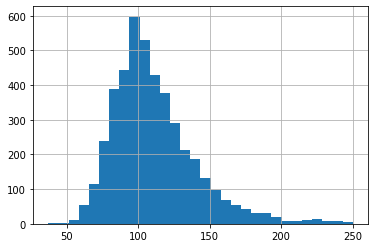

Распределение для (37412.0, 84869.0]
Количество значений: 4412


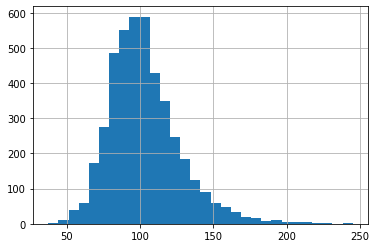

Столбец cityCenters_nearest
Распределение для (180.999, 9626.0]
Количество значений: 4431


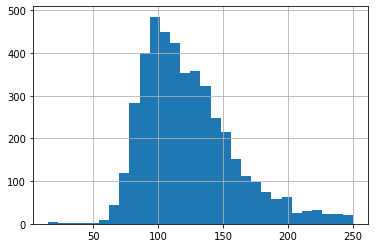

Распределение для (9626.0, 13222.0]
Количество значений: 4433


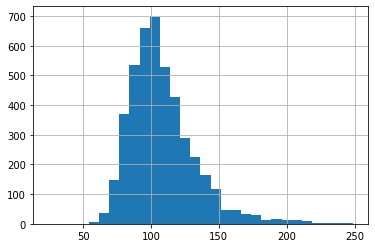

Распределение для (13222.0, 16381.0]
Количество значений: 4408


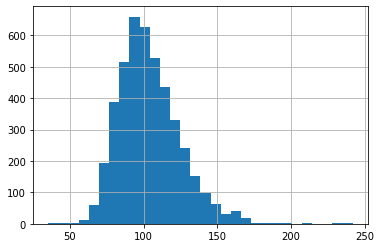

Распределение для (16381.0, 65968.0]
Количество значений: 4421


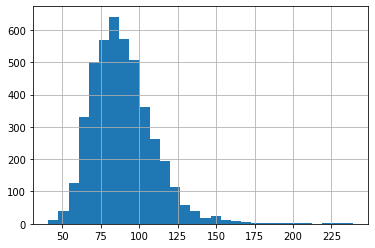

Столбец parks_around3000
Распределение для (-0.001, 1.0]
Количество значений: 20993


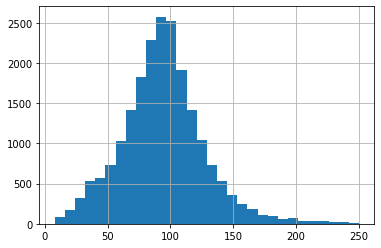

Распределение для (1.0, 3.0]
Количество значений: 2195


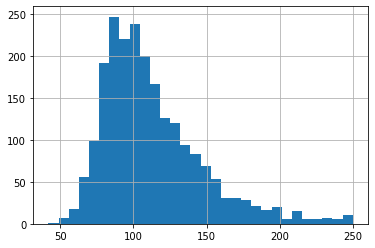

Столбец parks_nearest
Распределение для (0.999, 289.0]
Количество значений: 1938


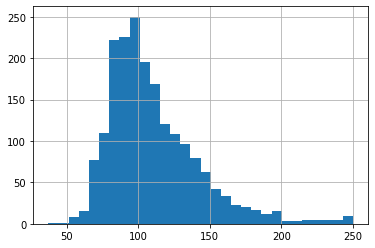

Распределение для (289.0, 456.0]
Количество значений: 1947


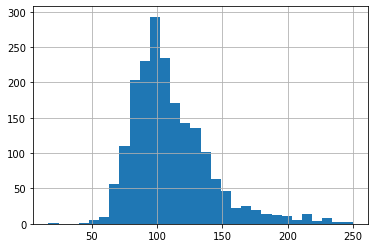

Распределение для (456.0, 614.0]
Количество значений: 1928


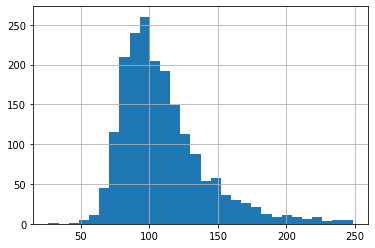

Распределение для (614.0, 3190.0]
Количество значений: 1933


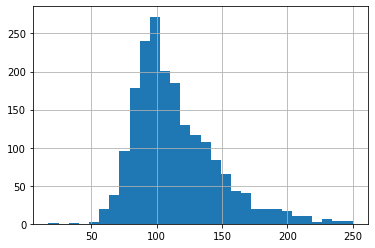

Столбец ponds_around3000
Распределение для (-0.001, 1.0]
Количество значений: 20051


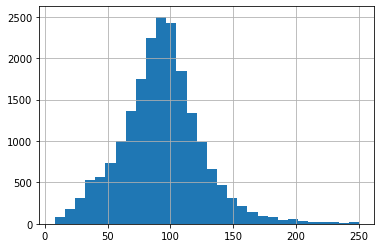

Распределение для (1.0, 3.0]
Количество значений: 3137


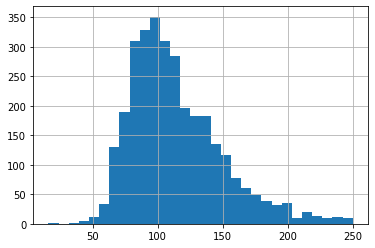

Столбец ponds_nearest
Распределение для (12.999, 303.0]
Количество значений: 2197


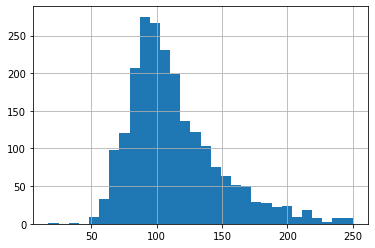

Распределение для (303.0, 508.0]
Количество значений: 2173


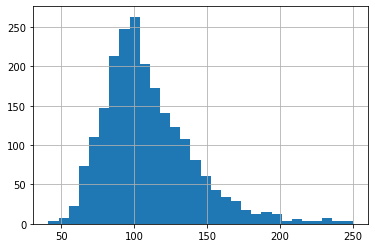

Распределение для (508.0, 734.0]
Количество значений: 2192


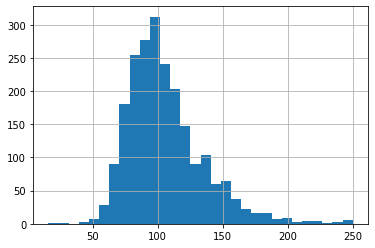

Распределение для (734.0, 1344.0]
Количество значений: 2177


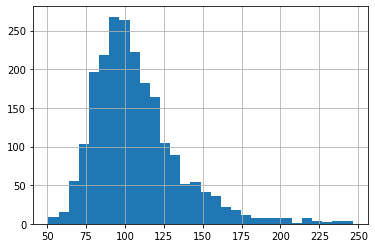

Столбец days_exposition
Распределение для (0.999, 45.0]
Количество значений: 7772


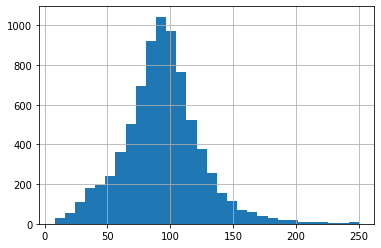

Распределение для (45.0, 94.0]
Количество значений: 3907


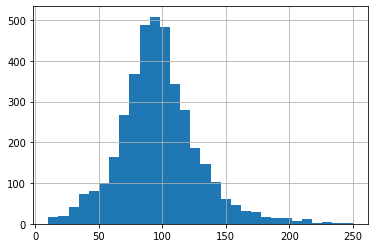

Распределение для (94.0, 228.75]
Количество значений: 4152


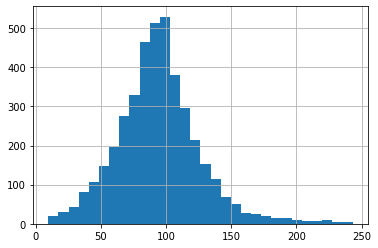

Распределение для (228.75, 1580.0]
Количество значений: 4299


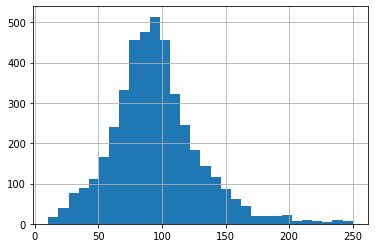

Столбец cost_per_square_meter
Распределение для (7.962, 76.19]
Количество значений: 5800


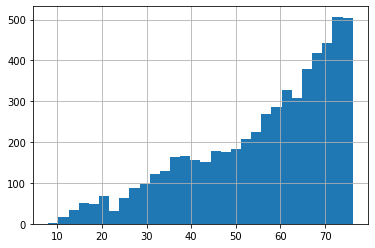

Распределение для (76.19, 94.501]
Количество значений: 5794


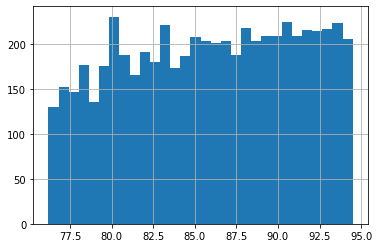

Распределение для (94.501, 113.158]
Количество значений: 5797


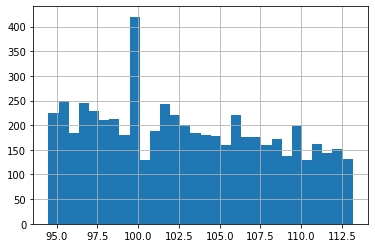

Распределение для (113.158, 250.0]
Количество значений: 5797


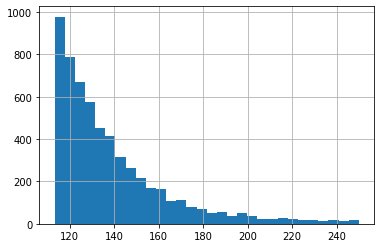

Столбец first_day_weekday
Распределение для (-0.001, 1.0]
Количество значений: 7640


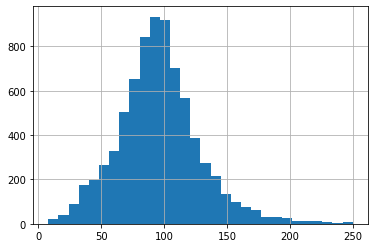

Распределение для (1.0, 3.0]
Количество значений: 8071


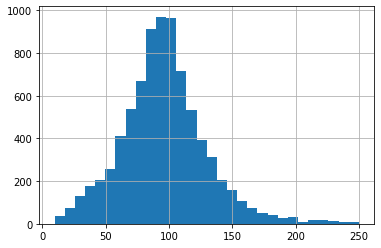

Распределение для (3.0, 4.0]
Количество значений: 3913


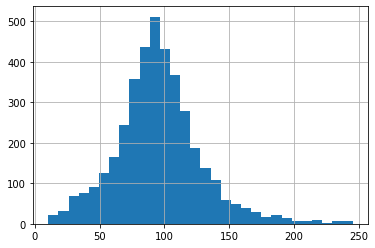

Распределение для (4.0, 6.0]
Количество значений: 3564


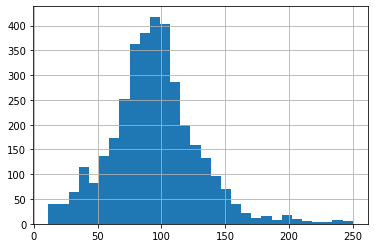

Столбец first_day_month
Распределение для (0.999, 3.0]
Количество значений: 6583


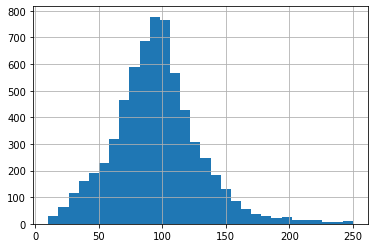

Распределение для (3.0, 6.0]
Количество значений: 5289


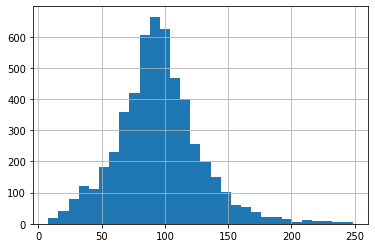

Распределение для (6.0, 10.0]
Количество значений: 7397


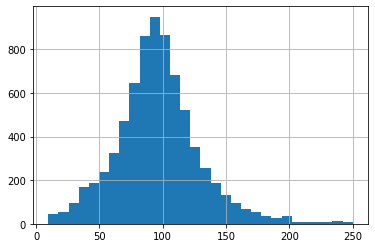

Распределение для (10.0, 12.0]
Количество значений: 3919


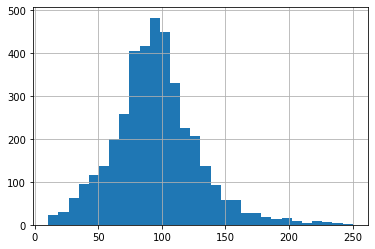

Столбец first_day_year
Распределение для (2013.999, 2017.0]
Количество значений: 11984


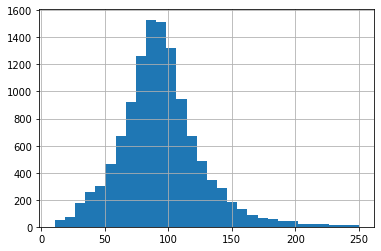

Распределение для (2017.0, 2018.0]
Количество значений: 8399


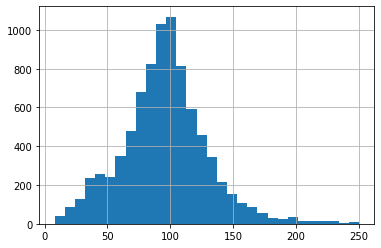

Распределение для (2018.0, 2019.0]
Количество значений: 2805


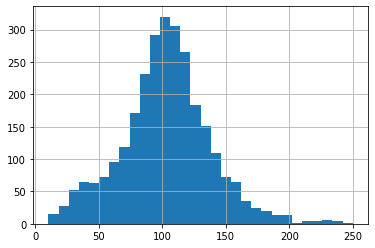

Столбец kitchen_area_amount
Распределение для (0.024399999999999998, 0.134]
Количество значений: 5244


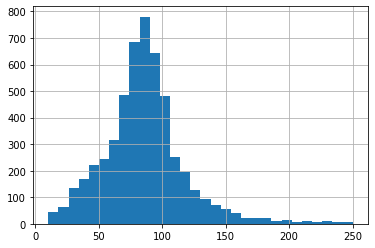

Распределение для (0.134, 0.173]
Количество значений: 5270


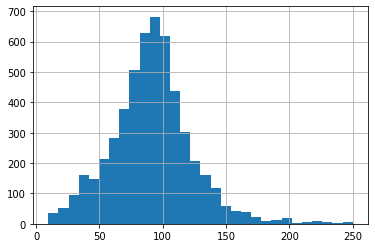

Распределение для (0.173, 0.233]
Количество значений: 5216


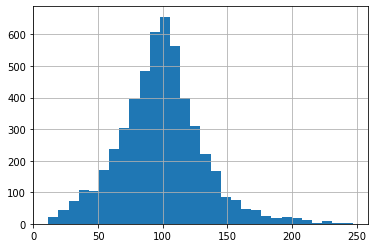

Распределение для (0.233, 0.788]
Количество значений: 5244


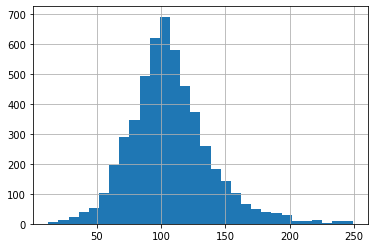

Столбец living_area_amount
Распределение для (0.0375, 0.495]
Количество значений: 5336


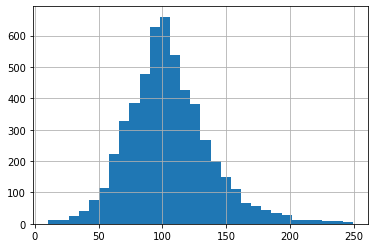

Распределение для (0.495, 0.568]
Количество значений: 5336


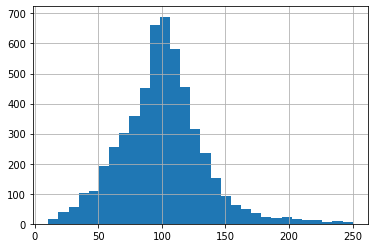

Распределение для (0.568, 0.637]
Количество значений: 5335


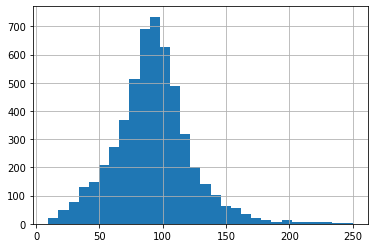

Распределение для (0.637, 1.0]
Количество значений: 5336


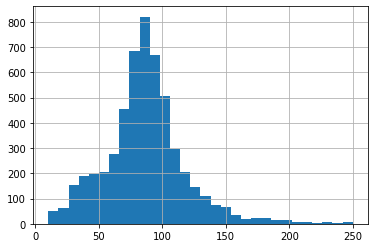

In [73]:
good_data = data_real_estate.query('wrong_value == 0')
print_hist_set_set_num(good_data)

Распределение для: floor_category
Распределение для другой
Количество значений: 16989


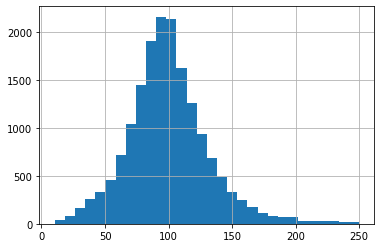

Распределение для неизвестно
Количество значений: 82


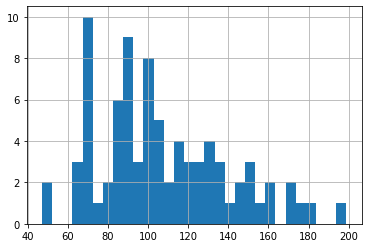

Распределение для первый
Количество значений: 2887


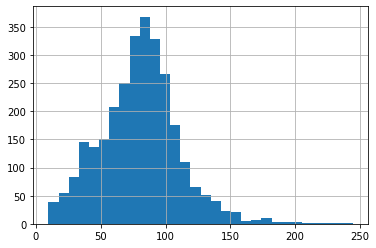

Распределение для последний
Количество значений: 3230


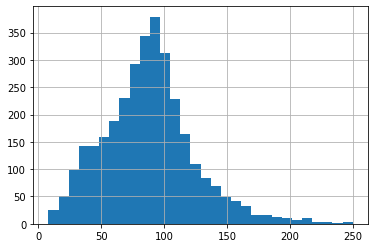

Распределение для: images_category
Распределение для мало
Количество значений: 7442


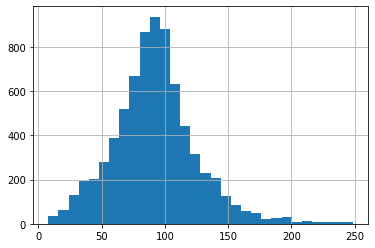

Распределение для много
Количество значений: 7125


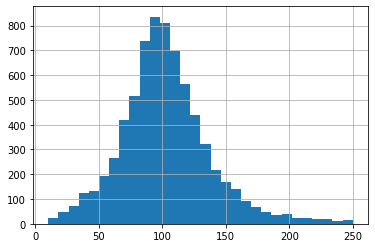

Распределение для нет фотографий
Количество значений: 1037


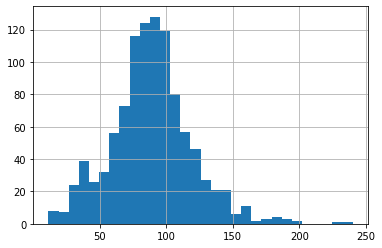

Распределение для средне
Количество значений: 7584


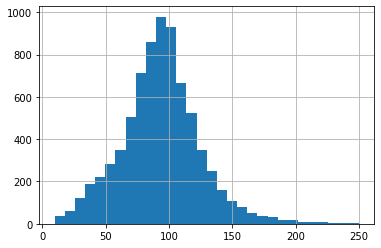

Распределение для: locality_name_category
Распределение для город
Количество значений: 19509


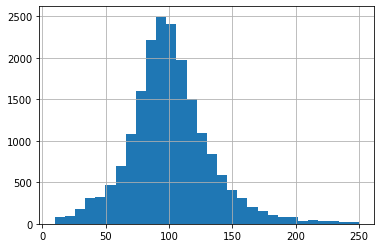

Распределение для другое
Количество значений: 3630


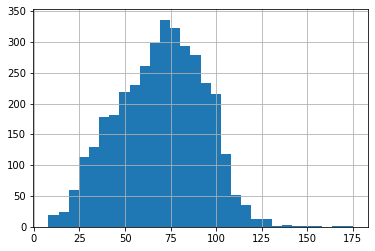

In [74]:
# распределение по категориям
for column in good_data.columns:
    if 'category' in column:
        print(color.BOLD + 'Распределение для:', column + color.END)
        print_hist_set(good_data, column)

Изучаю параметры по инструкции: площадь, цена, число комнат, высота потолков.

Выбросы успешно удалены.

In [75]:
top10_locals = data_real_estate['locality_name'].value_counts().head(10)
top10_locals_list = top10_locals.index.tolist()
data_top10_locals = data_real_estate.query('locality_name in @top10_locals_list')
data_top10_locals.shape[0]

18958

In [76]:
pivot_table_top10_locals = (
    data_top10_locals
    .pivot_table(index='locality_name', values='cost_per_square_meter', aggfunc='mean')
    .sort_values(by='cost_per_square_meter', ascending=False)
)
pivot_table_top10_locals

cost_per_square_meter
locality_name                           
Санкт-Петербург               114.849009
Пушкин                        103.125819
деревня Кудрово                92.473548
посёлок Парголово              90.175913
посёлок Мурино                 85.752189
посёлок Шушары                 78.677364
Колпино                        75.424579
Гатчина                        68.746147
Всеволожск                     68.654474
Выборг                         58.141909

#### Изучим время продажи квартиры:

In [77]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23188 entries, 0 to 23698
Data columns (total 32 columns):
total_images              23188 non-null int64
last_price                23188 non-null float64
total_area                23188 non-null float64
first_day_exposition      23188 non-null datetime64[ns]
rooms                     23188 non-null int64
ceiling_height            14174 non-null float64
floors_total              23103 non-null Int64
living_area               21343 non-null float64
floor                     23188 non-null int64
is_apartment              2702 non-null object
studio                    23188 non-null bool
open_plan                 23188 non-null bool
kitchen_area              20974 non-null float64
balcony                   23188 non-null Int64
locality_name             23139 non-null object
airports_nearest          17673 non-null float64
cityCenters_nearest       17693 non-null float64
parks_around3000          23188 non-null Int64
parks_nearest          

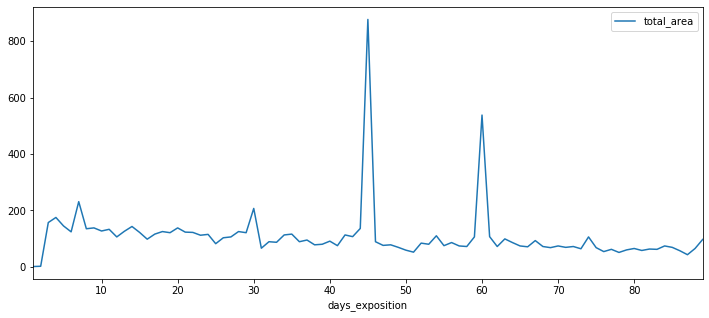

In [78]:
(good_data[good_data['days_exposition'].notna()]
     .query('days_exposition < 90')
     .pivot_table(index='days_exposition', values='total_area', aggfunc='count')
     .plot(figsize=(12,5))
)

2 странных пика на 45 и 60 дней с момента выставления... Роботы устанавливают и снимают объявления?..

In [79]:
good_data[good_data['days_exposition'].notna()]['days_exposition'].describe()

count    20130.000000
mean       178.979732
std        217.572282
min          1.000000
25%         45.000000
50%         94.000000
75%        228.750000
max       1580.000000
Name: days_exposition, dtype: float64

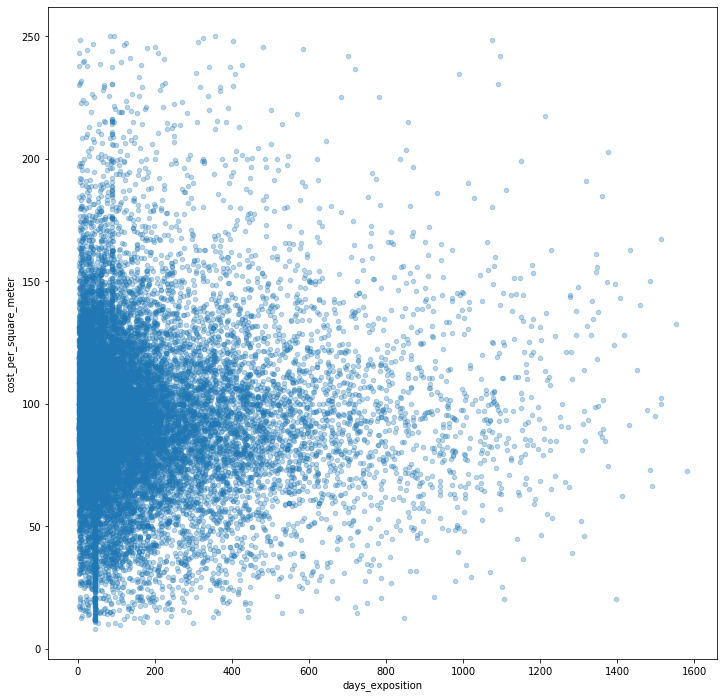

In [80]:
data_for_days_matrix = good_data[good_data['days_exposition'].notna()]
ax = data_for_days_matrix.plot(kind='scatter', alpha=0.3, x='days_exposition', y='cost_per_square_meter', figsize=(12,12))

Так же видны объявления, которые висели ровно 45 и 60 дней: 45 с заниженной ценой, 60 с завышенной.

**Задание:** Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья.

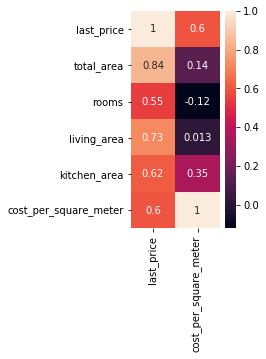

In [81]:
# найду корреляцию общей цены и цены за квадратный метр с остальными столбцами, чтобы выбрать лучший
# проверка корреляции на примере Санкт-Петербурга
def modul(data):
    return max(fabs(data['last_price']), fabs(data['cost_per_square_meter']))

spb_corr = good_data.query('locality_name == "Санкт-Петербург"').corr()
spb_corr = spb_corr[['last_price', 'cost_per_square_meter']]
spb_corr['abs'] = spb_corr.apply(modul,axis=1)
spb_corr = spb_corr.query('abs > 0.5')
spb_corr = spb_corr[['last_price', 'cost_per_square_meter']]
plt.figure(figsize=(2,4))
sns.heatmap(spb_corr, annot=True)

Большая корреляция наблюдается для столбца "общая цена". Его и будем использовать в дальнейшем. К тому же, в нём изначально не было пропусков.

Добавим столбцы для категорий (category id)

In [82]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23188 entries, 0 to 23698
Data columns (total 32 columns):
total_images              23188 non-null int64
last_price                23188 non-null float64
total_area                23188 non-null float64
first_day_exposition      23188 non-null datetime64[ns]
rooms                     23188 non-null int64
ceiling_height            14174 non-null float64
floors_total              23103 non-null Int64
living_area               21343 non-null float64
floor                     23188 non-null int64
is_apartment              2702 non-null object
studio                    23188 non-null bool
open_plan                 23188 non-null bool
kitchen_area              20974 non-null float64
balcony                   23188 non-null Int64
locality_name             23139 non-null object
airports_nearest          17673 non-null float64
cityCenters_nearest       17693 non-null float64
parks_around3000          23188 non-null Int64
parks_nearest          

Приведем категории к числовому типу:

In [83]:
for column in good_data:
    if 'category' in column:
        print(good_data[column].value_counts().head(10))

другой        16989
последний      3230
первый         2887
неизвестно       82
Name: floor_category, dtype: int64
средне            7584
мало              7442
много             7125
нет фотографий    1037
Name: images_category, dtype: int64
город     19509
другое     3630
Name: locality_name_category, dtype: int64


In [84]:
floor_ids = {'первый':1, 'другой':2, 'неизвестно': 3, 'последний': 4, None: -1, np.nan: -1}
images_ids = {'нет фотографий': 0, 'мало':1, 'средне': 2, 'много': 3, None: -1, np.nan: -1}
local_ids = {'город': 1, 'другое': 2, None: -1, np.nan: -1}
apartment_ids = {True: 1, False: 0, None: -1, np.nan: -1}
studio_ids = {True: 1, False:0, None: -1, np.nan: -1}
open_plan_ids = {True: 1, False: 0, None: -1, np.nan: -1}

In [85]:
good_data['floor_ids'] = good_data['floor_category'].apply(lambda x: floor_ids[x] + random.uniform(-0.4,0.4))
good_data['images_ids'] = good_data['images_category'].apply(lambda x: images_ids[x] + random.uniform(-0.4,0.4))
good_data['local_ids'] = good_data['locality_name_category'].apply(lambda x: local_ids[x] + random.uniform(-0.4,0.4))
good_data['apartment_ids'] = good_data['is_apartment'].apply(lambda x: apartment_ids[x] + random.uniform(-0.4,0.4))
good_data['studio_ids'] = good_data['studio'].apply(lambda x: studio_ids[x] + random.uniform(-0.4,0.4))
good_data['open_plan_ids'] = good_data['open_plan'].apply(lambda x: open_plan_ids[x] + random.uniform(-0.4,0.4))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [86]:
for column in good_data.select_dtypes('number').columns:
    good_data.loc[good_data[column].isnull(), column] = -good_data[column].median()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [87]:
scatter_columns = ['apartment_ids', 'studio_ids', 'open_plan_ids',
                   'total_area', 'rooms', 'balcony', 'ceiling_height', 'kitchen_area','living_area',
                   'kitchen_area_amount', 'living_area_amount',
                   'floor_ids', 'floor', 'floors_total',
                  'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest',
                   'parks_around3000', 'ponds_around3000',
                   'days_exposition','first_day_weekday', 'first_day_month', 'first_day_year', 
                   'images_ids', 'local_ids',
                  'cost_per_square_meter']

Распределение для apartment_ids


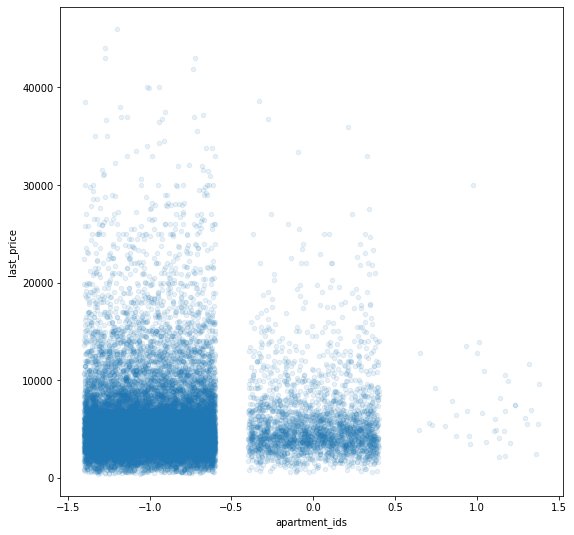

Распределение для studio_ids


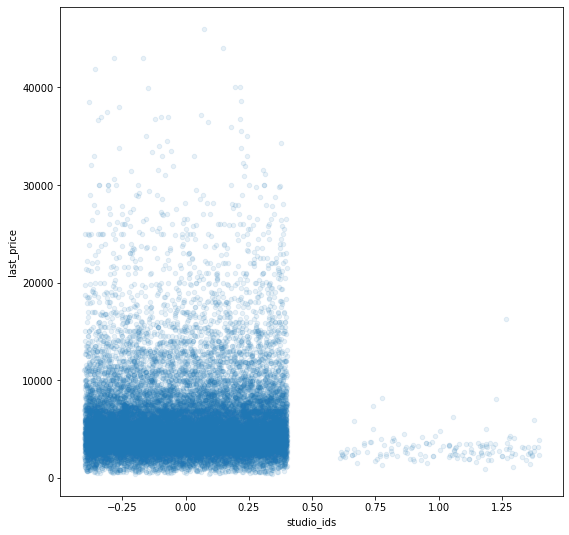

Распределение для open_plan_ids


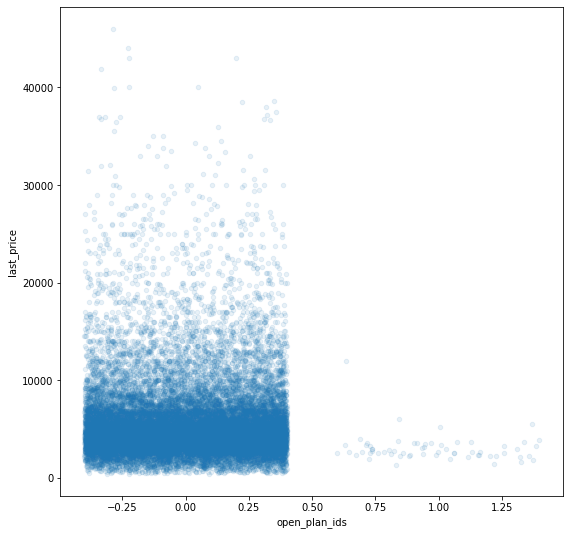

Распределение для total_area


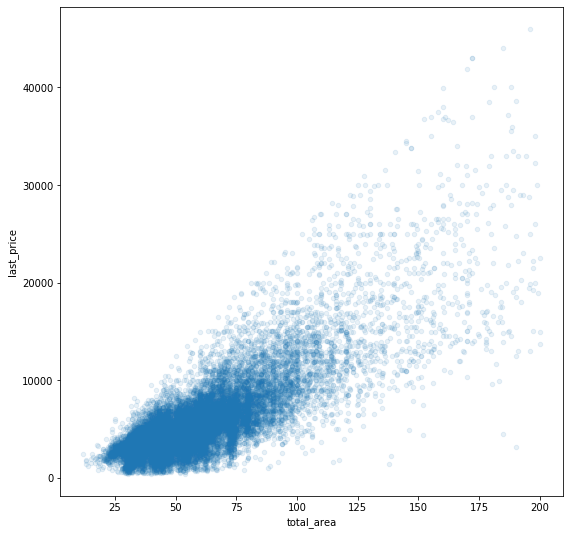

Распределение для rooms


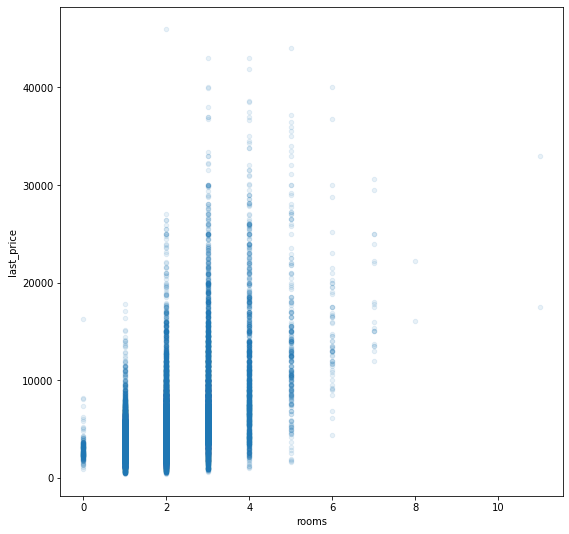

Распределение для balcony


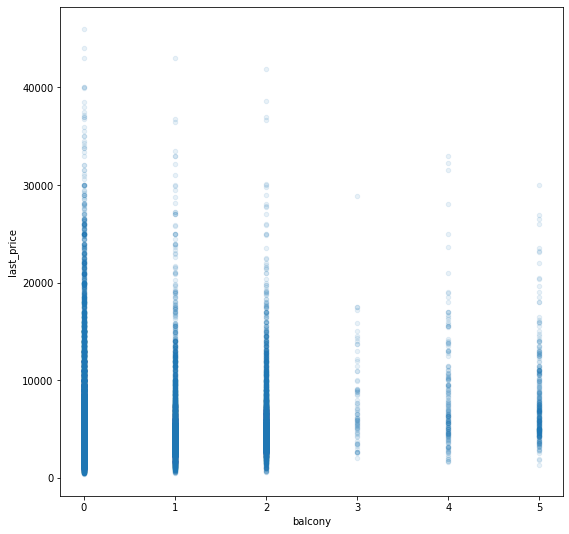

Распределение для ceiling_height


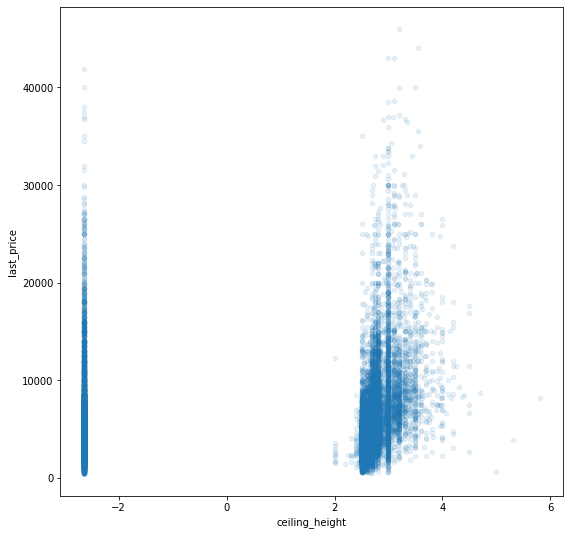

Распределение для kitchen_area


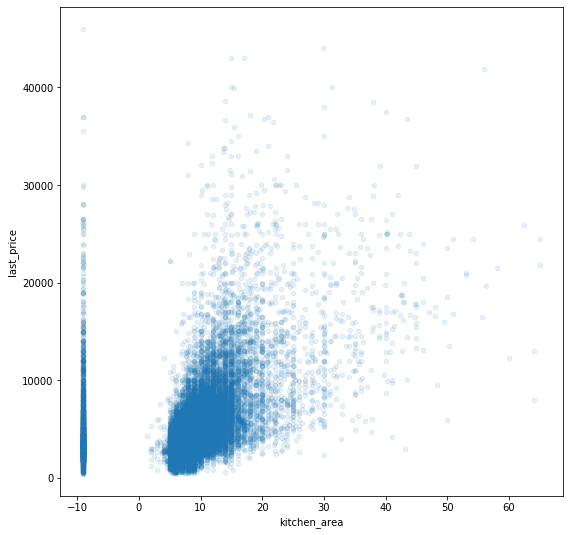

Распределение для living_area


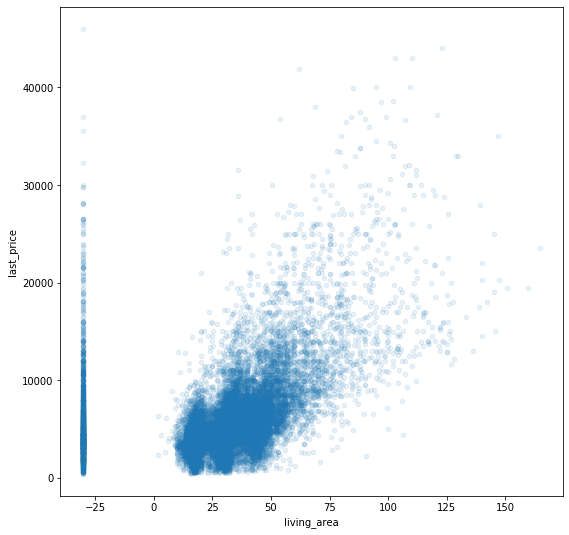

Распределение для kitchen_area_amount


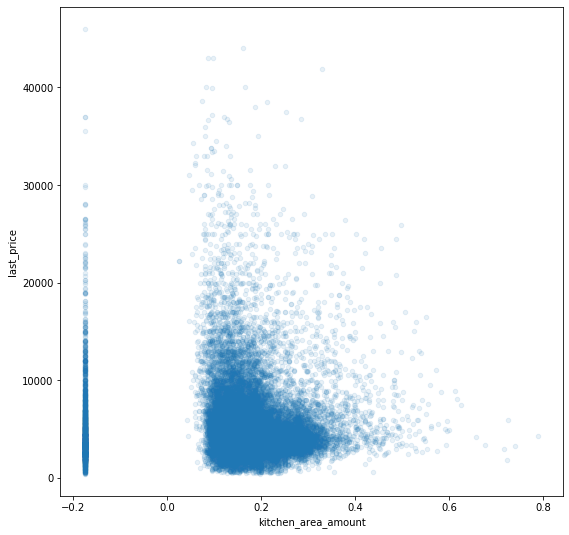

Распределение для living_area_amount


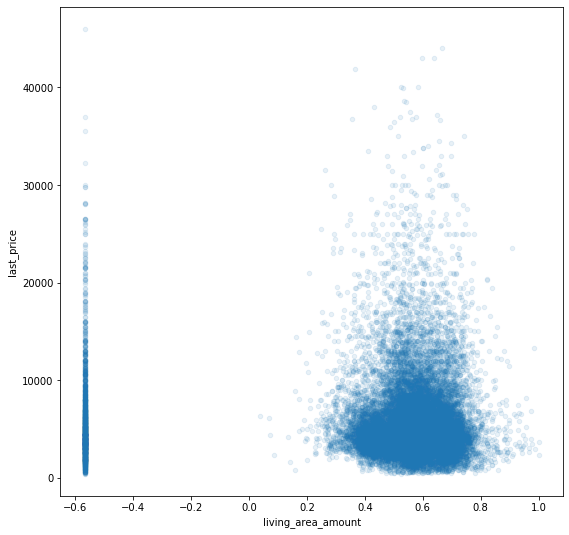

Распределение для floor_ids


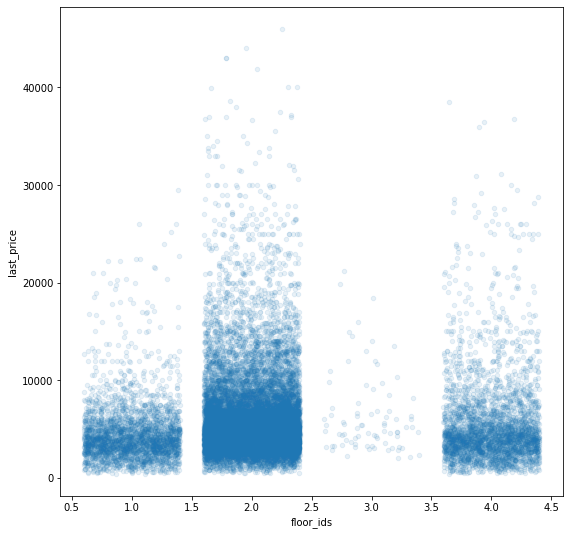

Распределение для floor


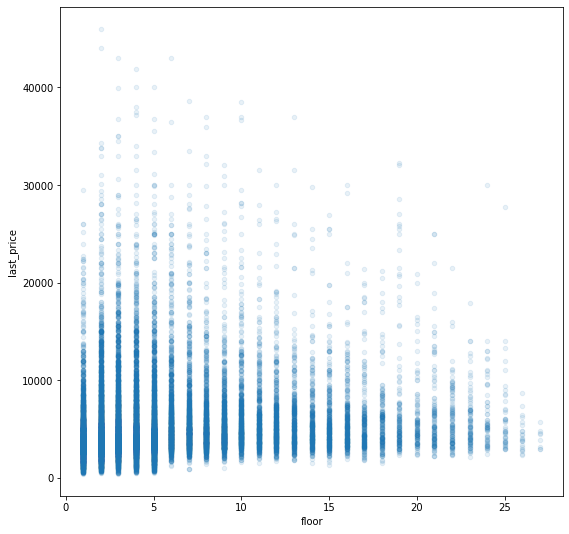

Распределение для floors_total


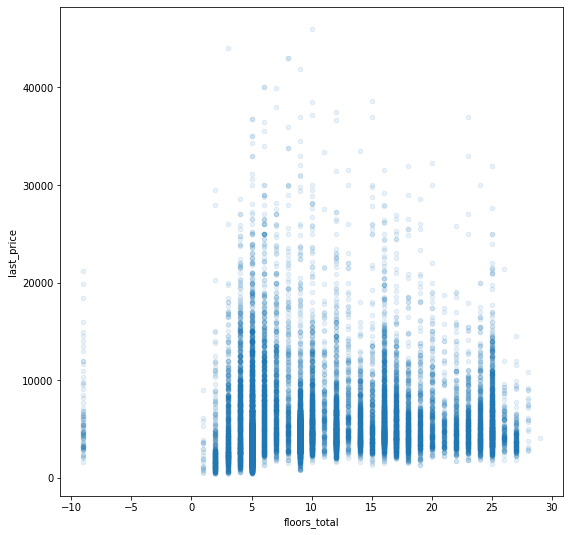

Распределение для airports_nearest


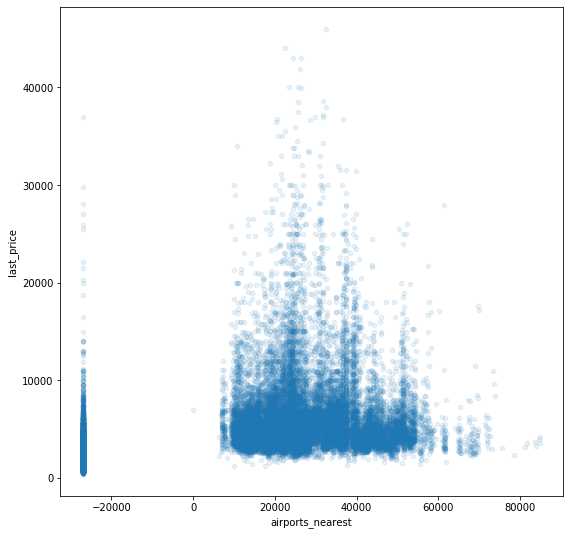

Распределение для cityCenters_nearest


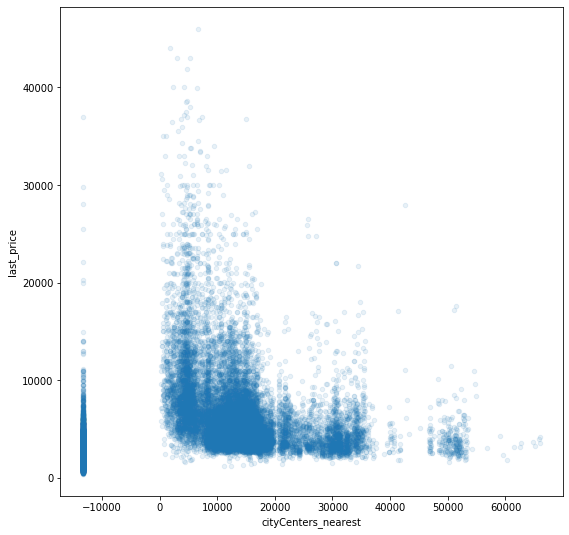

Распределение для parks_nearest


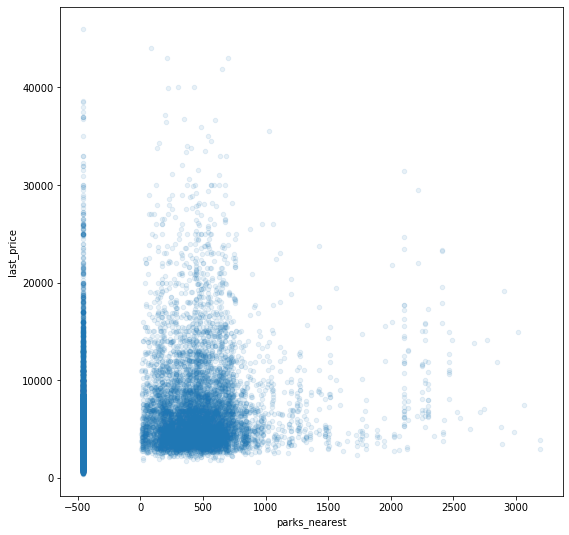

Распределение для ponds_nearest


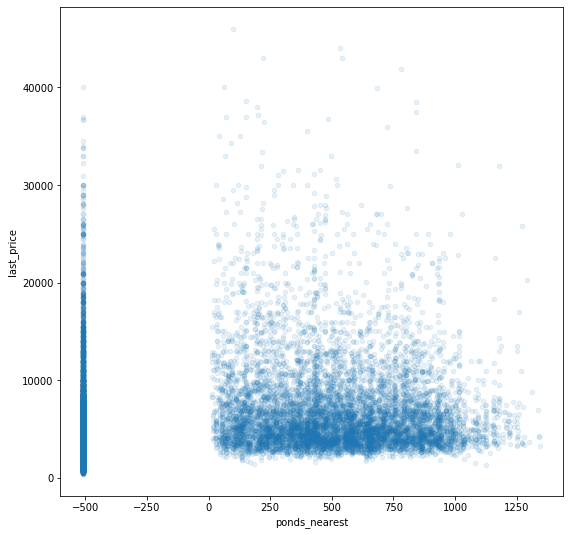

Распределение для parks_around3000


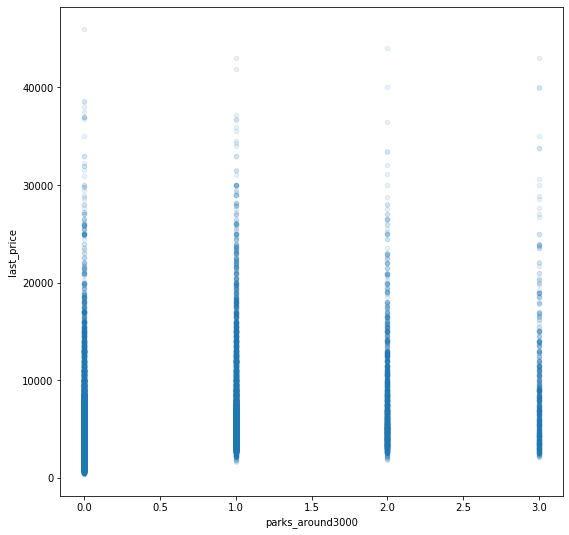

Распределение для ponds_around3000


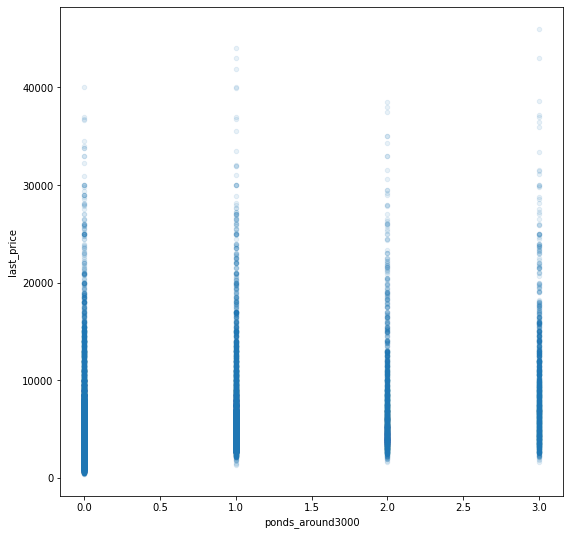

Распределение для days_exposition


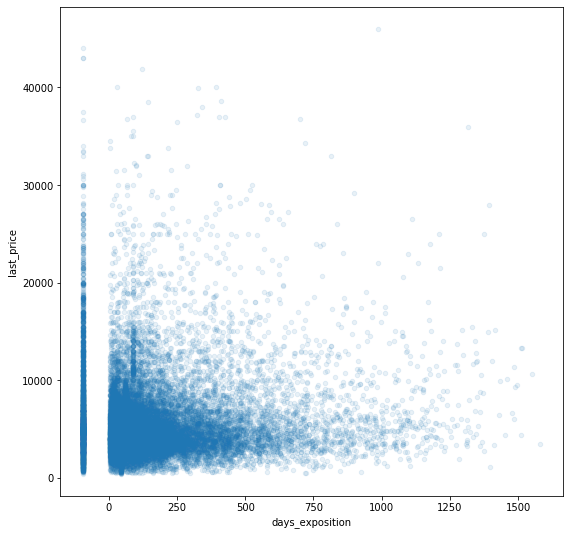

Распределение для first_day_weekday


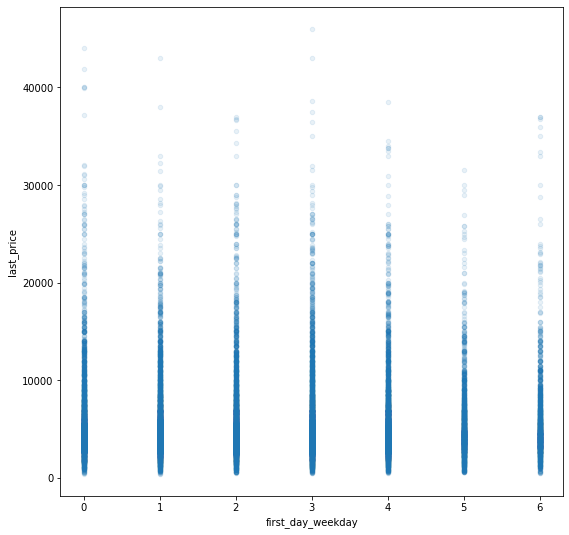

Распределение для first_day_month


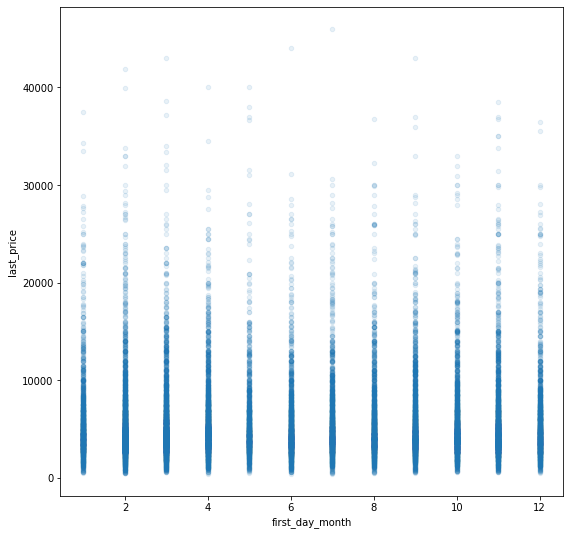

Распределение для first_day_year


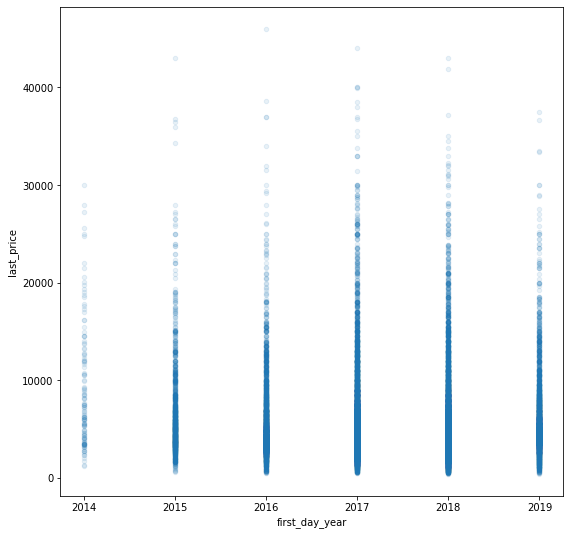

Распределение для images_ids


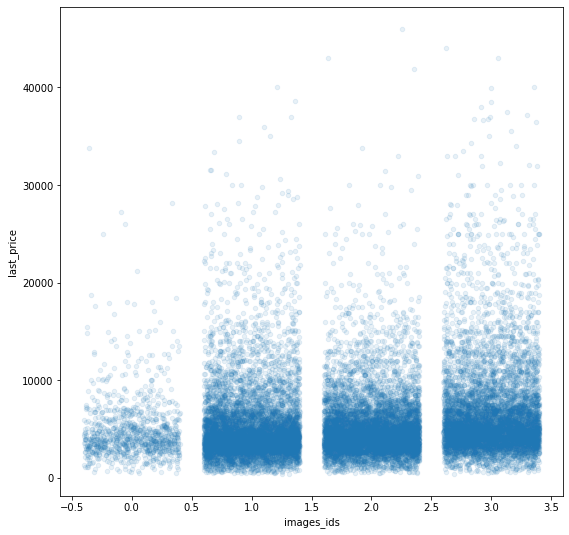

Распределение для local_ids


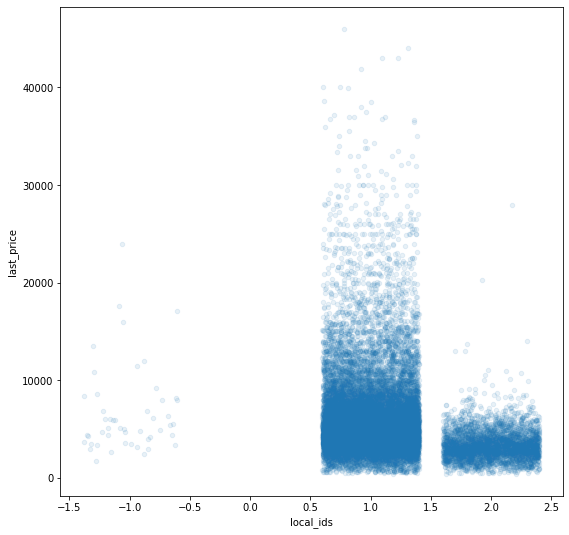

Распределение для cost_per_square_meter


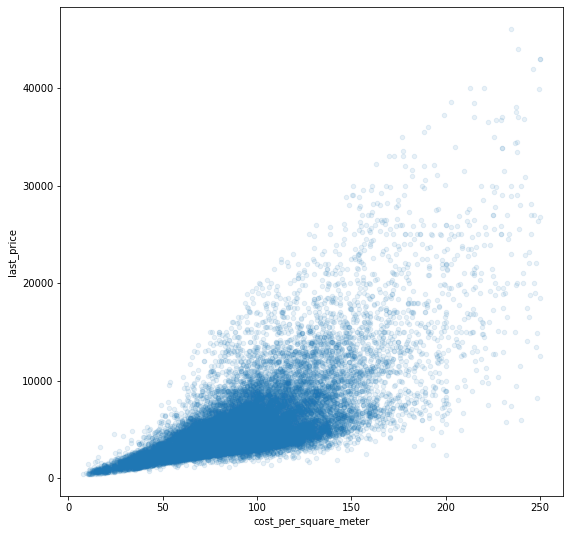

In [88]:
for column in scatter_columns:
    print(color.BOLD + 'Распределение для ' + column + color.END)
    good_data.plot(kind='scatter', alpha=0.1, x=column, y='last_price', figsize=(9,9))
    plt.show()

In [89]:
good_data.groupby('locality_name_category')['last_price'].describe()

count         mean          std    min     25%  \
locality_name_category                                                     
город                   19509.0  6112.333122  4173.360596  430.0  3699.0   
другое                   3630.0  3350.414680  1561.852398  430.0  2350.0   

                           50%     75%      max  
locality_name_category                           
город                   4900.0  7049.0  46000.0  
другое                  3150.0  4100.0  28000.0

In [90]:
good_data.groupby('floor_category')['last_price'].describe()

count         mean          std     min     25%       50%  \
floor_category                                                                
другой          16989.0  5922.214818  4052.675536   450.0  3590.0  4800.000   
неизвестно         82.0  6554.901927  4210.373466  1995.0  3612.5  5242.239   
первый           2887.0  4482.525808  2954.926007   430.0  2780.0  3900.000   
последний        3230.0  5463.456304  4381.707681   430.0  2950.0  4250.000   

                     75%        max  
floor_category                       
другой          6800.000  46000.000  
неизвестно      7523.265  21187.872  
первый          5325.000  29500.000  
последний       6400.000  38500.000

In [91]:
good_data.groupby('first_day_year')['last_price'].describe()

count         mean          std     min     25%     50%  \
first_day_year                                                             
2014.0           127.0  9332.565512  6459.152781  1200.0  4275.0  7300.0   
2015.0          1138.0  6602.010506  4800.947954   650.0  3700.0  5200.0   
2016.0          2706.0  5630.750036  3996.075434   490.0  3370.0  4450.0   
2017.0          8013.0  5607.516307  4047.815431   450.0  3320.0  4490.0   
2018.0          8399.0  5498.953911  3798.216932   430.0  3350.0  4500.0   
2019.0          2805.0  5948.003538  3903.267061   430.0  3700.0  5000.0   

                       75%      max  
first_day_year                       
2014.0          12763.5000  29999.0  
2015.0           7511.3715  43000.0  
2016.0           6500.0000  46000.0  
2017.0           6500.0000  44000.0  
2018.0           6402.6665  43000.0  
2019.0           7000.0000  37500.0

**Вывод:**
- *Последняя цена для апартаментов*: не указано в подавляющем количестве объявлений. В целом цена на такие объявления выше.
- *студия, открытая планировка*: на студии цена гораздо ниже.
- *общая площадь*: более сильная зависимость наблюдается у нижней границы цены, начиная от 100 метров квадратных идёт больший разброс. Можно предположить, что большие площади могут быть за городом, как в богатых, так и в бедных районах.
- *комнаты*: значительный разброс цен на наждый набор комнат, однако наибольшая максимальная цена наблюдается на 3-4 комнатные квартиры, очевидно, это наиболее распространенный вариант для престижных квартир в центре.
- *Балконы*: интересная корреляция. Вполне согласуется с тем, что в новостройках сейчас в моде плоские фасады, без балконов и лоджий, поэтому первичный рынок жилья отражен в первом столбце и цена на такие квартиры выше.
- *Высота потолков*: 3 метра распределение от минимальной цены до максимальной. Можно предположить, что большинство не заморачивается с измерением при продаже и ставит 3 метра. Почти 40% вообще решили не указывать эти данные, так что выглядит логично. Прямой зависимости цены от высоты потолков нет.
- *Площадь кухни*: наиболее часто встречающиеся – от 5 до 15. В этом диапазоне большая степень корреляции.
- *Жилая площадь*: от 10 до 50, корреляция с ценой слабая.
- *Доля кухни в общей площади*: нет связи с ценой. Большая цена квартир тяготеет к меньшей части общей площади в них. Предполагаю, в связи с тем, что дорогие квартиры в целом больше по площади, чем дешевые, и при меньшей доле кухни в общей площади лпощадь кухни может быть даже больше.
- *Доля жилой площади в общей*: нет связи с ценой. Более дорогие квартиры тяготеют к среднему соотношению 0,5-0,6 в общей площади.
- *Тип этажа*: наименее престижны первые этажи, затем последние, и где-то посередине – цена больше всего.
- *Номер этажа*: 3-4-й наиболее престижные.
- *Всего этажей* – слабая зависимость. Чуть больше максимальная цена у 5-этажных домов.
- *Аэропорты поблизости*: слабая зависимость. Наблюдается повышение максимальной цены в районе 25-40 км до аропорта.
- *Центры городов поблизости* – в пределах 5 км минимальная цена чуть выше, но прямой зависимости нет.
- *Парки поблизости* – Зависимости нет.
- *Водоемы поблизости* – аналогично.
- *Количество парков/водоемов поблизости* – не влияет.
- *Количество дней, сколько было выставлено объявление* – не влияет.
- *Первый день, когда было выставлено объявление* – слабая зависимость.
- *Месяц выставления объявления* – слабая зависимость.
- *Год выставления объявления* – 2017-2018 – максимальная цена выше, потом идёт на спад.
- *Количество изображений* – в целом без фото цена ниже.
- *Город/другое* – цена определенно выше в городах, что логично.

Больше всего на цену влияют:
- Квартиры в городах дороже приблизительно в 2 раза.
- Площадь квартиры до 100 кв. метров имеет большую корреляцию с ценой.
- Нет балкона - выше цена.
- Номер этажа: наименьшая цена в среднем у первых этажей, потом последние, и выше всего - у средних (+33% по сравнению с первыми).

Средняя цена у 10 самых продаваемых населенных пунктов:

In [92]:
# 10 населенных пунктов с наибольшим числом объявлений - средняя цена
print(color.BOLD + 'Средняя цена квадратного метра, тыс. р.' + color.END)
for index, value in good_data['locality_name'].value_counts().head(10).iteritems():
    print('{: <20}'.format(index), '{: >17.2f}'.format(data_real_estate.
                                 query('locality_name == @index')['cost_per_square_meter'].mean()))

Средняя цена квадратного метра, тыс. р.
Санкт-Петербург                 114.85
посёлок Мурино                   85.75
посёлок Шушары                   78.68
Всеволожск                       68.65
Пушкин                          103.13
Колпино                          75.42
посёлок Парголово                90.18
Гатчина                          68.75
деревня Кудрово                  92.47
Выборг                           58.14


Населенные пункты с самой высокой и низкой стоимостью жилья:

In [93]:
localities_stat = (
      good_data
     .pivot_table(index='locality_name', values='last_price', aggfunc=['mean', 'count'])
     .sort_values(by=[('mean','last_price')], ascending=False)
)
localities_stat.columns = ['last_price_mean', 'count']
localities_stat = localities_stat.query('count > 10')

print('Наибольшая цена в среднем в:', localities_stat.index[0])
print('Наименьшая средняя цена в:', localities_stat.index[-1])

Наибольшая цена в среднем в: Санкт-Петербург
Наименьшая средняя цена в: Бокситогорск


**Задание**: Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

Все населенные пункты, сроки размещения объявления


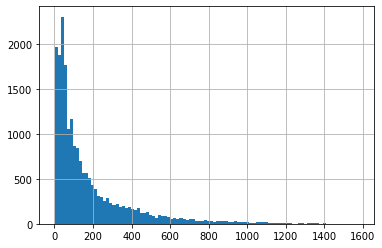

In [94]:
print(color.BOLD + 'Все населенные пункты, сроки размещения объявления' + color.END)
ax = good_data.query('days_exposition > 0')['days_exposition'].hist(bins=100)

Не похоже ни на нормальное распределение, ни на Пуассоновское. Дополнительно проверю по городу.

In [95]:
# список населенных пунктов с наибольшим количеством предложений
good_data['locality_name'].value_counts()

Санкт-Петербург                                            15241
посёлок Мурино                                               520
посёлок Шушары                                               440
Всеволожск                                                   397
Пушкин                                                       363
                                                           ...  
садовое товарищество Садко                                     1
поселок Тёсово-4                                               1
поселок Ромашки                                                1
садоводческое некоммерческое товарищество Лесная Поляна        1
поселок Жилгородок                                             1
Name: locality_name, Length: 362, dtype: int64

Всеволожск, сроки размещения объявления


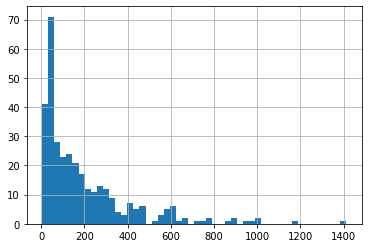

In [96]:
print(color.BOLD + 'Всеволожск, сроки размещения объявления' + color.END)
ax = (good_data.query('days_exposition > 0 and locality_name == "Всеволожск"')
      ['days_exposition']
     .hist(bins=50)
)

Больше шумы, но картина повторяется. Посмотрим распределение в целом:

In [97]:
good_data.query('days_exposition > 0')['days_exposition'].describe()

count    20130.000000
mean       178.979732
std        217.572282
min          1.000000
25%         45.000000
50%         94.000000
75%        228.750000
max       1580.000000
Name: days_exposition, dtype: float64

In [98]:
good_data['days_exposition'].quantile(0.95)

598.0

График имеет форму гиперболы, и чем меньше срок, тем больше квартир продаются за единицу времени. Очень быстро квартира продастся - менее, чем за 1,5 месяца, она войдет в четверть всех продаваемых квартир. Слишком долго (позже 95%) - после 616 дней, около 1 и 2/3 года.

**Задание** Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

In [99]:
spb_data = good_data.query('locality_name == "Санкт-Петербург"')

In [100]:
spb_data.loc[:,'cityCentre_km'] = spb_data.loc[:,'cityCenters_nearest'].astype('Int64')
spb_data.loc[:,'cityCentre_km'] = spb_data.loc[:,'cityCentre_km'] // 1000 

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [101]:
print(spb_data[['cityCenters_nearest', 'cityCentre_km']].head(5))

   cityCenters_nearest  cityCentre_km
0              16028.0             16
2              13933.0             13
4               8098.0              8
7              11634.0             11
9              15008.0             15


График средней цены на квартиры в СПб в зависимости от расстояния до центра


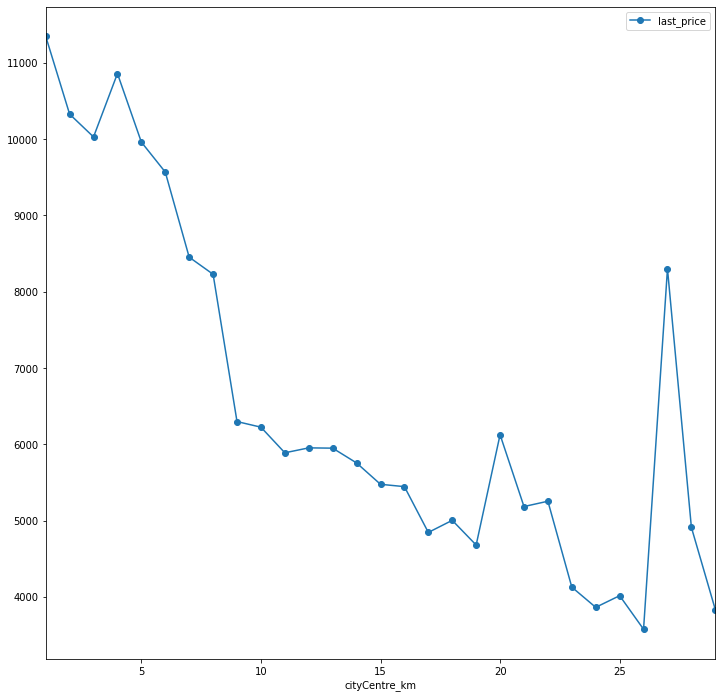

In [102]:
print(color.BOLD + 'График средней цены на квартиры в СПб в зависимости от расстояния до центра' + color.END)
ax = (spb_data
     .query('cityCentre_km > 0')
     .pivot_table(index='cityCentre_km', values='last_price', aggfunc='mean')
     .sort_values(by='cityCentre_km', ascending=False)
     .plot(figsize=(12,12),style='o-')
)

Центром можно считать зону до 10 км, так как дальше цена падает не так резко, начиная с 6 млн. р. Дальнейшие всплески на 20 и 25+ км связаны очевидно с дорогой загородной недвижимостью.

**Задание** Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

В целом по городу:

In [103]:
# столбцы для анализа
hist_columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']
scatter_columns = ['rooms', 'floor_ids', 'cityCentre_km', 'first_day_weekday', 'first_day_month', 'first_day_year']

In [104]:
spb_centre_data = spb_data.query('cityCentre_km <= 10')

total_area


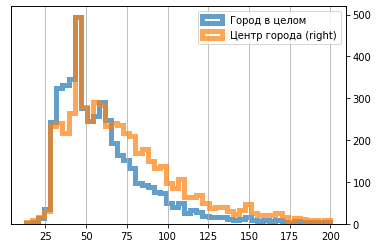

last_price


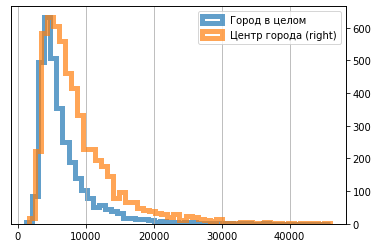

rooms


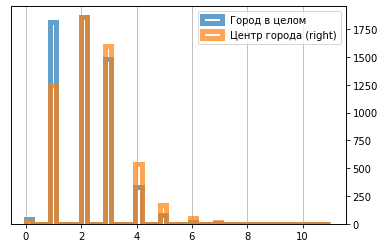

ceiling_height


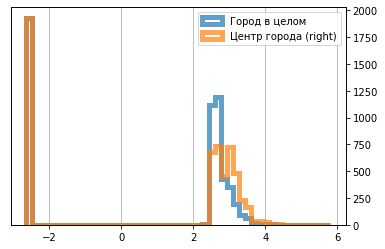

In [105]:
for column in hist_columns:
    print(color.BOLD + column + color.END)
    ax = (spb_data
        .query('cityCentre_km > 0')
        .plot(kind='hist', bins=50, y=column, histtype='step', linewidth=5, alpha=0.7,
                     label='Город в целом', grid=True, legend=True)
    )
    (spb_centre_data
         .query('cityCentre_km > 0')
         .plot(kind='hist', bins=50, y=column, histtype='step', linewidth=5, alpha=0.7,
                     label='Центр города', grid=True, secondary_y=True, legend=True, ax=ax)
    )
    plt.show()

rooms


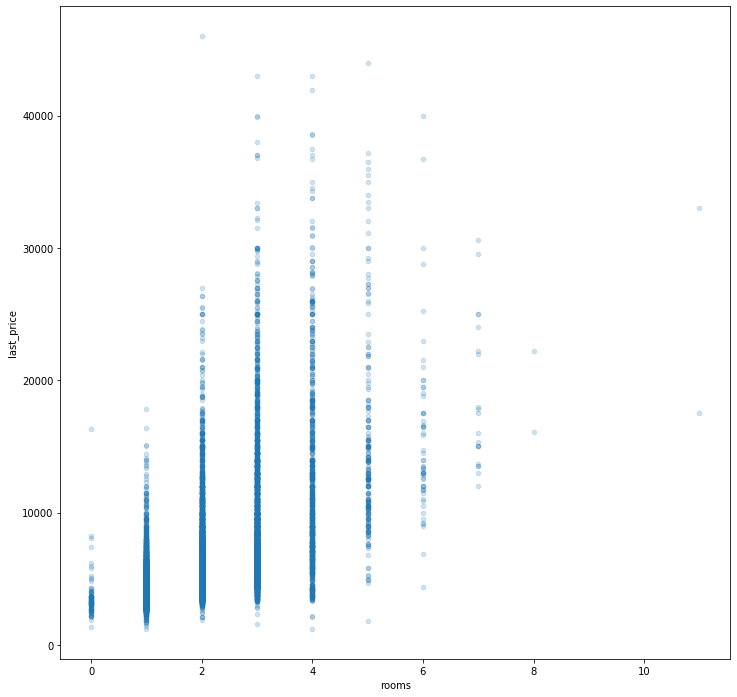

floor_ids


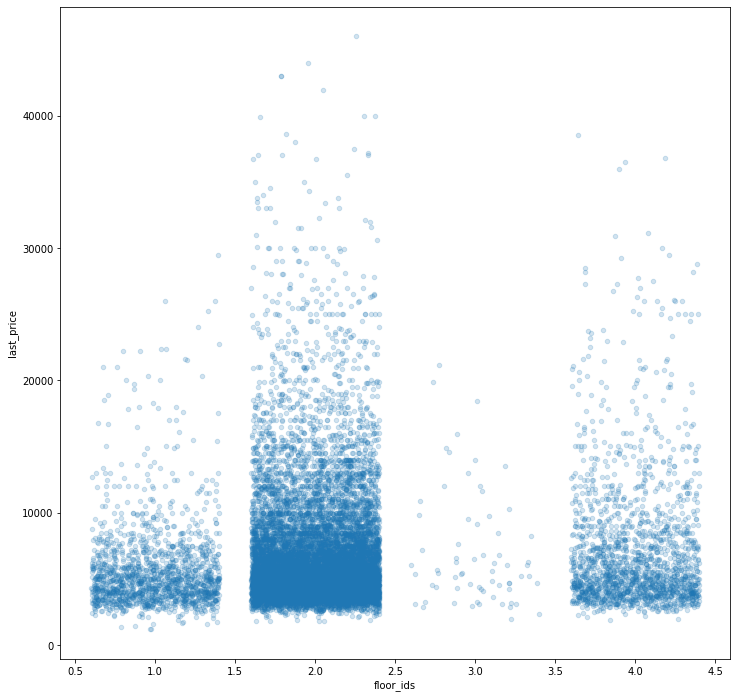

cityCentre_km


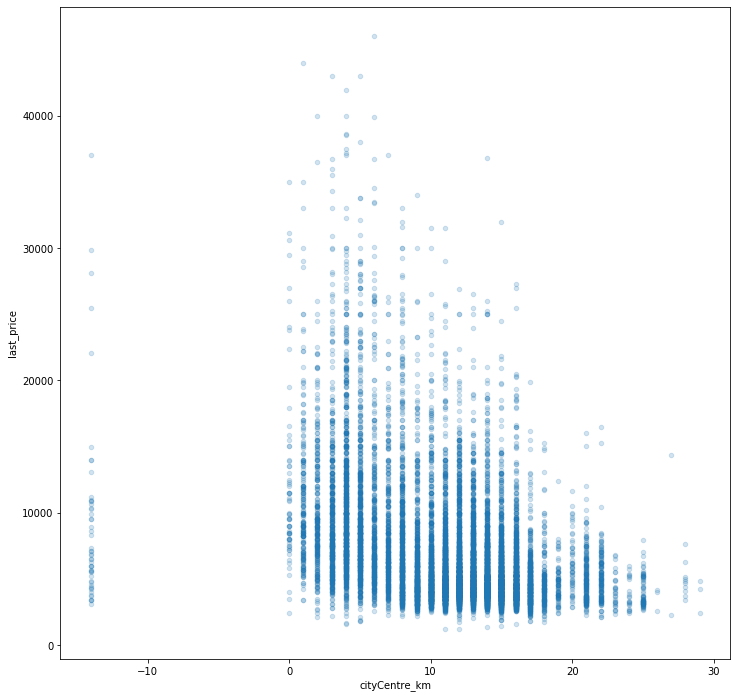

first_day_weekday


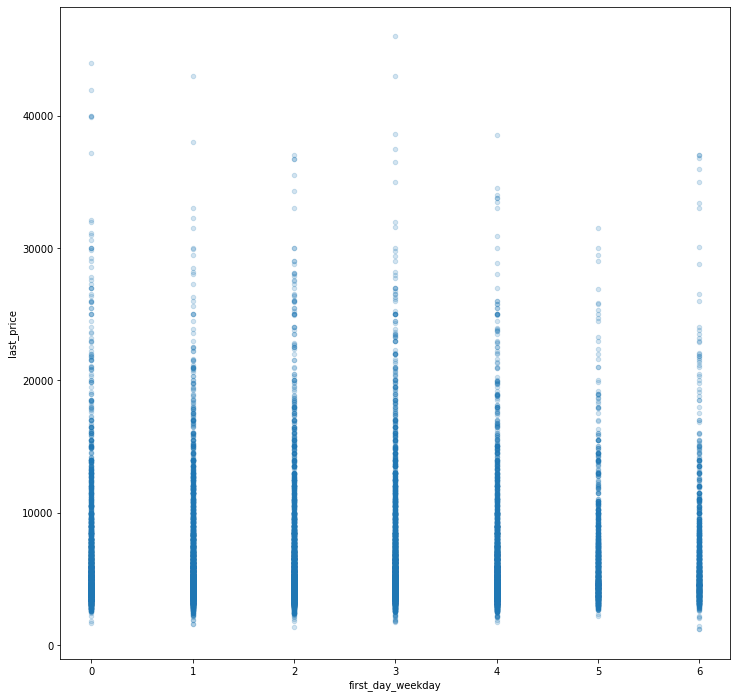

first_day_month


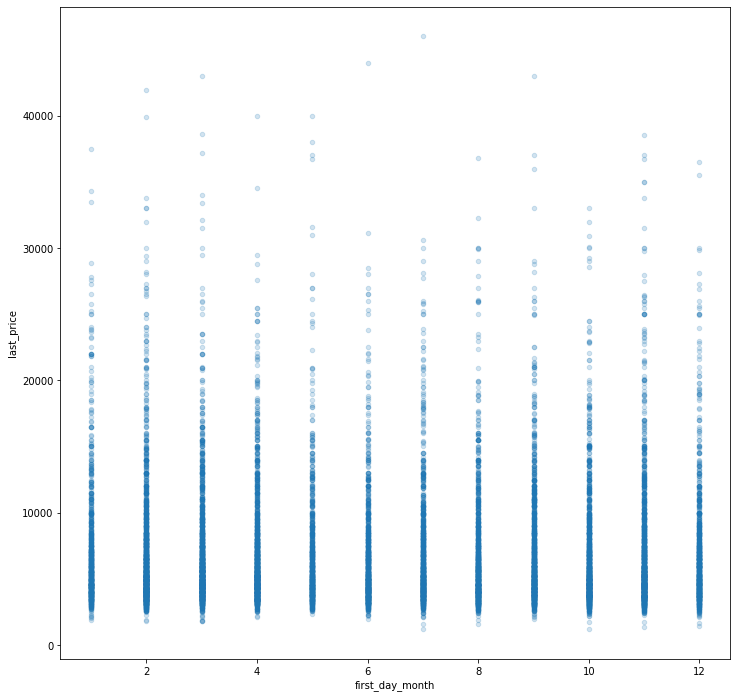

first_day_year


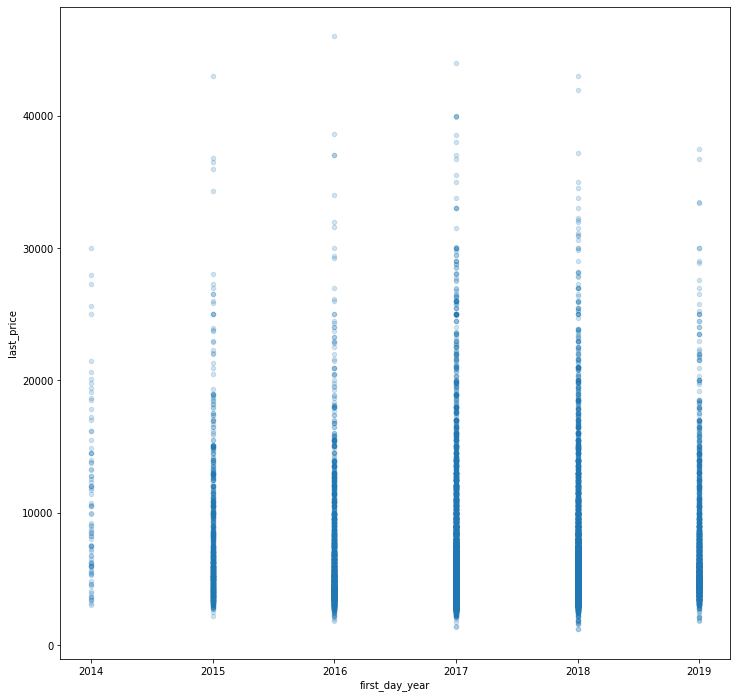

In [106]:
for column in scatter_columns:
    print(color.BOLD + column + color.END)
    ax = (spb_data
     .plot(kind='scatter', x=column, alpha=0.2, y='last_price', figsize=(12,12))
    )
    plt.show()

rooms


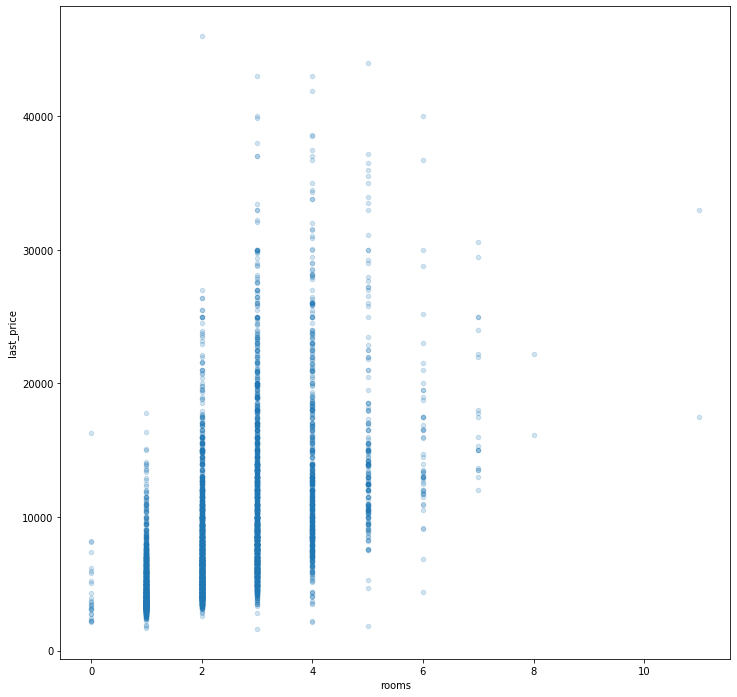

floor_ids


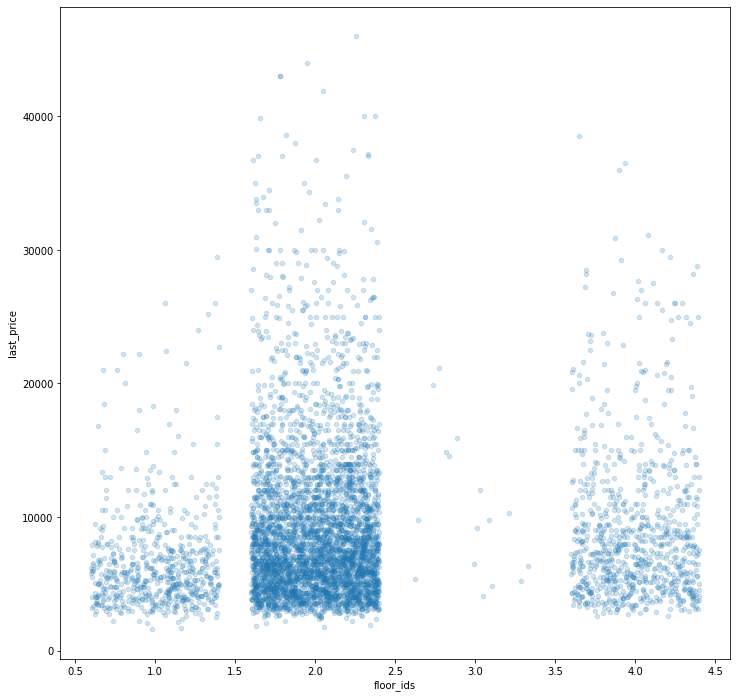

cityCentre_km


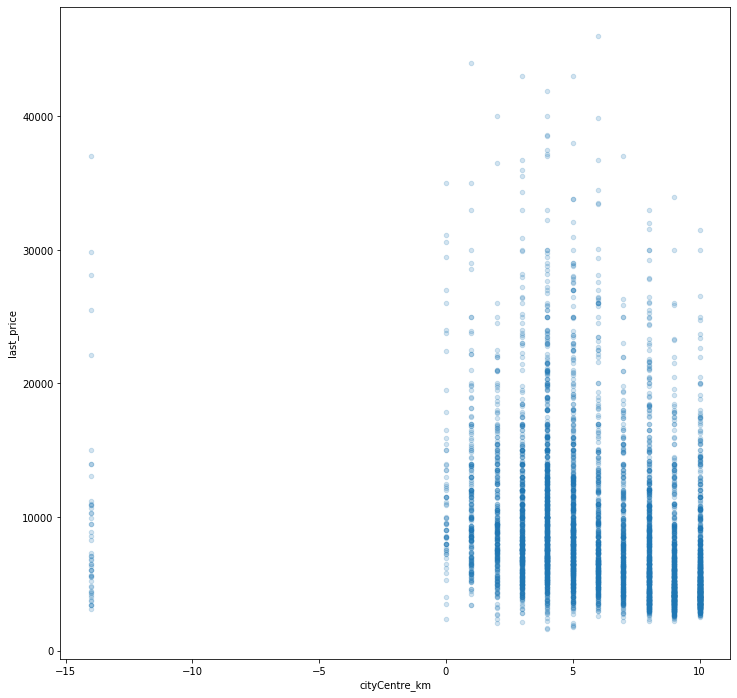

first_day_weekday


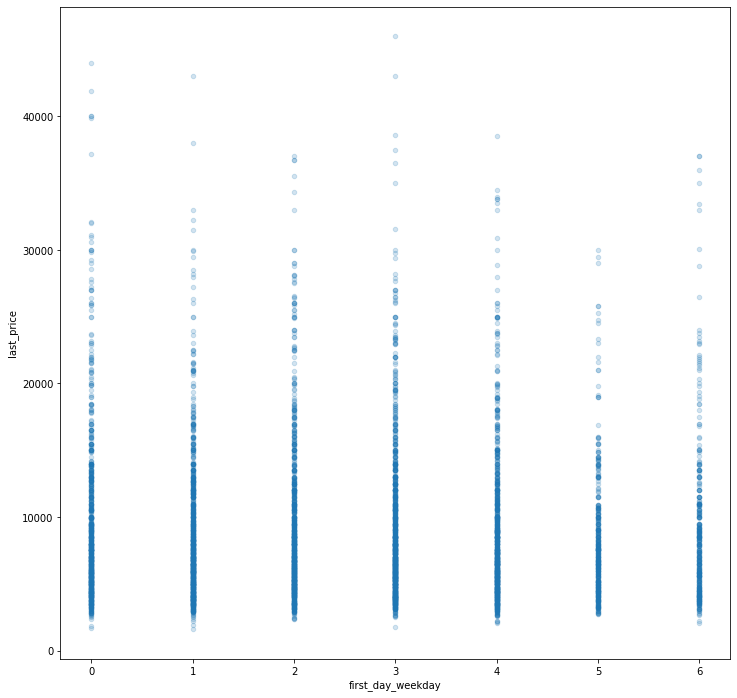

first_day_month


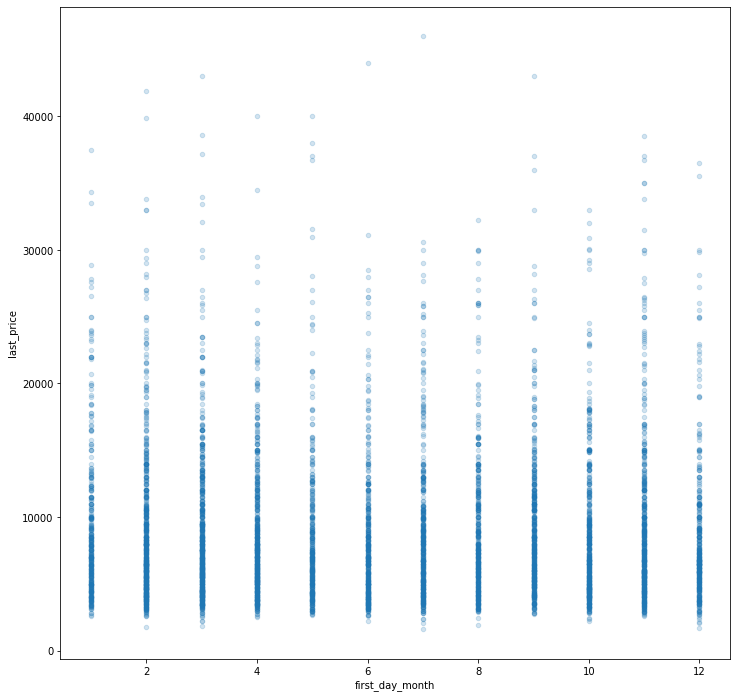

first_day_year


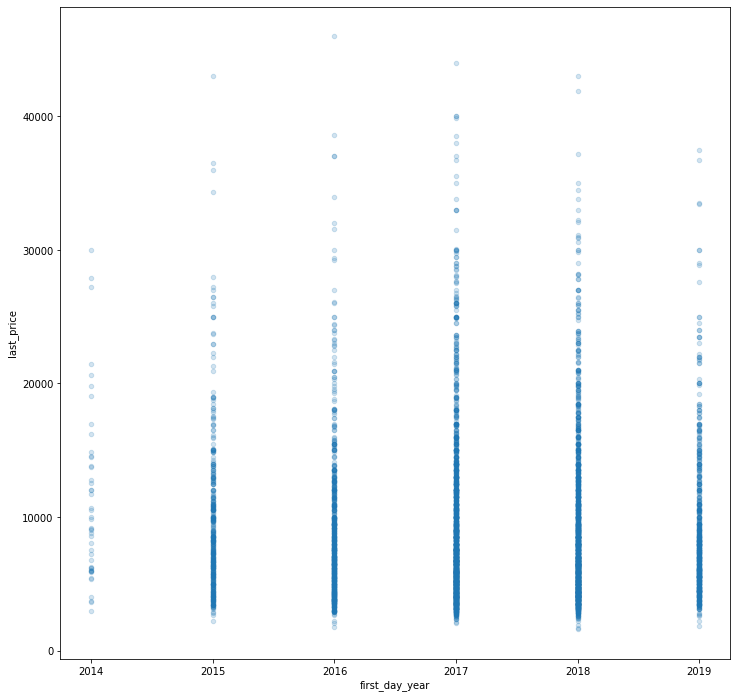

In [107]:
for column in scatter_columns:
    print(color.BOLD + column + color.END)
    (spb_centre_data
     .plot(kind='scatter', x=column, alpha=0.2, y='last_price', figsize=(12,12))
    )
    plt.show()

In [108]:
spb_data.query('cityCentre_km >= 0')['last_price'].describe()

count    15190.000000
mean      6807.015632
std       4305.033753
min       1190.000000
25%       4200.000000
50%       5447.537500
75%       7800.000000
max      46000.000000
Name: last_price, dtype: float64

In [109]:
spb_centre_data['last_price'].describe()

count     5633.000000
mean      8815.119072
std       5530.849820
min       1600.000000
25%       5095.000000
50%       7200.000000
75%      10700.000000
max      46000.000000
Name: last_price, dtype: float64

In [110]:
# окраина
spb_data.query('cityCentre_km >= 10')['last_price'].describe()

count    10513.000000
mean      5693.484897
std       2912.017148
min       1190.000000
25%       3950.000000
50%       4900.000000
75%       6400.000000
max      36800.000000
Name: last_price, dtype: float64

**В целом по городу:**
- общая площадь: 30-40 м
- средняя цена – 6,8 млн., на окраине - 3 млн.
- больше всего распространены 1-3 комнатные квартиры
- высота потолков – 2,5-3,5 м

**По центру:**
- общая площадь: 40-60 м
- средняя цена - 8.9 млн, на 2.1 млн. больше общей цены
- количество квартир : доля 1-комнатных уменьшилась на 20%, 4-комнатных увеличилась на 10%.
- высота потолков – такая же.

### Шаг 5. Общий вывод

**Ознакомление с данными:**
В первоначальном наборе данных не хватает указания типа дома (кирпичный, монолит, шлакоблок и т.п.), и особенно такой важной категории, как первичный или вторичный рынок жилья. По логике этот параметр сильно должен влиять на цену. Отсутствие этих важных параметров смазывает итоговые результаты.

При первоначальном анализе данных было выявлено несколько типов пропущенных значений:
- пропущенные при автоматическом подсчёте (сбой или недоработка алгоритма):
  - расстояние до ближайшего парка/водоема, аэропорта/центра города. Определено, что у таких объявлений нет этих объектов поблизости, данные исправлены.
- пропущенные логически (напр. если балкона нет, люди пропускают этот шаг, и не указывают явно "нет". Исправлено, сходится со статистикой с сайтов по продаже недвижимости.
- пропуски в столбце, апартаменты ли это. Отсутствуют почти у 90% данных. Анализ рынка жилья не позволяет сделать вывод, что все пропущенные значения - не апартаменты, т.к. их сейчас больше, около 40%. Не заполнял этот столбец.
- восьмая часть объявлений не имеет данных о количестве дней, сколько было выставлено объявление. Было определено, что это всё - незакрытые объявления.
- пропусков в названии населенных пунктов - пренебрежимо мало (0.2%).

**Работа с пропусками:**
Кроме того, были замечены и исправлены некорректные типы данных:
- дата выставления объявления записана как строка
- некоторые численные значения приведены к типу Int64 для хранения одновременно и пропусков, и целых значений.

Как некорректные данные были выявлены крайние значения для важных параметров:
- общей площади - более 200 кв.м.
- высоты потолков - менее 2 и больше 6
- общего количества этажей - более 30.
- стоимость за квадратный метр - менее 4 тыс (по данным cian.ru Для старых домов в глубинке) и более 250 тыс. р/м.кв.

**Добавление столбцов**:
Добавил дополнительные столбцы, с нормированными данными:
- отношение *площади кухни/жилой к общей*

Добавил столбцы с категоризацией:
- *количество фотографий* - на равные группы
- *населенный пункт* - город/нет
- *этажей*: первый/последний/другой/не указан
- *дата*: день недели, месяц, год

**Анализ:**
Было проведено сравнение степени корреляции для общей цены и цены за квадратный метр с другими параметрами, общая цена коррелирует чуть больше, её я использовал для дальнейшего анализа.

При определении центра города было отмечено, что стоимость жилья перестаёт быстро убывать начиная с 10 км (и 6 млн. р.), это расстояние и было определено как радиус, за пределами которого начинаются спальные районы.
Если квартира продалась за 1,5 месяца, она входит по скорости в четверть проданных квартир. Слишком долго (позже 95%) - после 616 дней, около 1 и 2/3 года.

Собранная статистика:

*В целом по городу:*
- общая площадь: 30-40 м
- средняя цена – 6,8 млн.
- больше всего распростране5ны 1-3 комнатные квартиры
- высота потолков – 2,5-3,5 м

*По центру:*
- общая площадь: 40-60 м
- средняя цена - 8.9 млн, на 2.1 млн. больше общей цены
- количество квартир : доля 1-комнатных уменьшилась на 20%, 4-комнатных увеличилась на 10%.
- высота потолков – такая же.


При анализе было определены параметры, в наибольшей степени влияющие на стоимость жилья:
- город это или другой населенный пункт - разница почти в 2 раза.
- центр города или окраина - разница 33% (8,9 млн. против 5,7).

**Странные встречающиеся значения:** *сколько дней было размещено объявление* - 45, 60, 7, 30, 90 - неделя, месяц, полтора, два, три. Можно предположить, что какой-то робот устанавливает их и снимает по четкому графику.